In [5]:
#Loading libraries
import os
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.fundamentaldata import FundamentalData
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime
import time
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import plotly.graph_objects as go
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats

## 1. Access Alpha Vantage API 

In [9]:
#Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

#Read API key from file
api_key = read_api_key('ApiKeys.txt')

#Setup Alpha Vantage API
ts = TimeSeries(key=api_key, output_format='pandas')
fd = FundamentalData(key=api_key, output_format='pandas')
#Read stock symbols from a file
with open('stocks.txt', 'r') as file:
    stocks = [line.strip() for line in file if line.strip()]

## 2. Fetch Stock Data

In [13]:
import time
import pandas as pd
from datetime import datetime, timedelta
from alpha_vantage.timeseries import TimeSeries

# Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Read API key
api_key = read_api_key('ApiKeys.txt')

# Setup Alpha Vantage API
ts = TimeSeries(key=api_key, output_format='pandas')

# Define stock symbols by cap size
large_cap_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO']
mid_cap_stocks = ['PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT']
small_cap_stocks = ['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']

# Combine all stocks into one list
all_stocks = large_cap_stocks + mid_cap_stocks + small_cap_stocks

# Calculate start date for the timeframe (2 years back from November 26th, current year)
end_date = datetime(2024, 11, 26)
start_date = end_date - timedelta(days=2 * 365)  # Approximation for 2 years

# Dictionaries to hold data for daily and weekly prices
daily_data = {}
weekly_data = {}

# Fetch daily and weekly data for each stock
for stock in all_stocks:
    try:
        # Throttle API calls to respect rate limits
        time.sleep(20)  # Adjust if needed, based on API key's rate limits

        # First Step: Fetch daily data
        daily, _ = ts.get_daily_adjusted(symbol=stock, outputsize='full')
        daily.index = pd.to_datetime(daily.index)  # Convert index to datetime
        daily = daily.loc[(daily.index >= start_date) & (daily.index <= end_date)]  # Filter by timeframe
        daily.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. adjusted close': 'Adj Close',
            '6. volume': 'Volume',
            '7. dividend amount': 'Dividend',
            '8. split coefficient': 'Split Coefficient'
        }, inplace=True)
        daily['Stock'] = stock
        daily_data[stock] = daily

        #Second Step: Fetch weekly data
        weekly, _ = ts.get_weekly_adjusted(symbol=stock)
        weekly.index = pd.to_datetime(weekly.index)  # Convert index to datetime
        weekly = weekly.loc[(weekly.index >= start_date) & (weekly.index <= end_date)]  # Filter by timeframe
        weekly.rename(columns={
            '1. open': 'Open',
            '2. high': 'High',
            '3. low': 'Low',
            '4. close': 'Close',
            '5. adjusted close': 'Adj Close',
            '6. volume': 'Volume'
        }, inplace=True)
        weekly['Stock'] = stock
        weekly_data[stock] = weekly

        print(f"Fetched data for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")
        
# COMBINE AND SAVE STOCK DATA 
# Combine all data into single DataFrames
all_daily_data = pd.concat(daily_data.values()).reset_index().rename(columns={'index': 'Date'})
all_weekly_data = pd.concat(weekly_data.values()).reset_index().rename(columns={'index': 'Date'})

# Save to CSV files for backup
all_daily_data.to_csv('all_daily_data.csv', index=False)
all_weekly_data.to_csv('all_weekly_data.csv', index=False)

# Filter data for each cap size
large_cap_daily = all_daily_data[all_daily_data['Stock'].isin(large_cap_stocks)]
mid_cap_daily = all_daily_data[all_daily_data['Stock'].isin(mid_cap_stocks)]
small_cap_daily = all_daily_data[all_daily_data['Stock'].isin(small_cap_stocks)]

large_cap_weekly = all_weekly_data[all_weekly_data['Stock'].isin(large_cap_stocks)]
mid_cap_weekly = all_weekly_data[all_weekly_data['Stock'].isin(mid_cap_stocks)]
small_cap_weekly = all_weekly_data[all_weekly_data['Stock'].isin(small_cap_stocks)]

# Output success message
print("Daily and Weekly data successfully fetched and organized!")


Fetched data for AAPL
Fetched data for MSFT
Fetched data for GOOGL
Fetched data for AMZN
Fetched data for TSLA
Fetched data for META
Fetched data for NVDA
Fetched data for CSCO
Fetched data for PATH
Fetched data for INFA
Fetched data for OTEX
Fetched data for CIEN
Fetched data for ALRM
Fetched data for NCNO
Fetched data for CRVL
Fetched data for NSIT
Fetched data for INOD
Fetched data for AMPL
Fetched data for PUBM
Fetched data for INSG
Fetched data for SMTC
Fetched data for AGYS
Fetched data for RMBS
Fetched data for COHU
Daily and Weekly data successfully fetched and organized!


## 3. Calculate Log Returns 

In [25]:
# Function to calculate log returns and remove unwanted columns
def calculate_log_returns(data):
    """
    Calculates the log returns for the given data and drops unnecessary columns.

    Parameters:
        data (pd.DataFrame): DataFrame containing stock data with 'Adj Close'.

    Returns:
        pd.DataFrame: DataFrame with an added 'Log Return' column and unnecessary columns dropped.
    """
    # Drop '7. dividend amount' column if it exists
    if '7. dividend amount' in data.columns:
        data = data.drop(columns=['7. dividend amount'])
    
    # Calculate log returns
    data['Log Return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    return data

# Recalculate daily log returns with the updated function
daily_log_returns = {}
for stock, df in daily_data.items():
    daily_log_returns[stock] = calculate_log_returns(df)

# Combine all daily data with log returns into a single DataFrame
all_daily_log_returns = pd.concat(daily_log_returns.values()).reset_index().rename(columns={'index': 'Date'})

# Recalculate weekly log returns with the updated function
weekly_log_returns = {}
for stock, df in weekly_data.items():
    weekly_log_returns[stock] = calculate_log_returns(df)

# Combine all weekly data with log returns into a single DataFrame
all_weekly_log_returns = pd.concat(weekly_log_returns.values()).reset_index().rename(columns={'index': 'Date'})

# Output success message
print("Log returns calculated for both daily and weekly data, with '7. dividend amount' removed!")

# Display the first 5 rows of daily log returns
print("\nFirst 5 rows of daily log returns:")
all_daily_log_returns.head()

# Display the first 5 rows of weekly log returns
print("\nFirst 5 rows of weekly log returns:")
all_weekly_log_returns.head()

Log returns calculated for both daily and weekly data, with '7. dividend amount' removed!

First 5 rows of daily log returns:

First 5 rows of weekly log returns:


,date,Open,High,Low,Close,Adj Close,Volume,Stock,Log Return
0,2024-11-22,225.25,230.7199,225.17,229.87,229.8700,196343939.0,AAPL,NaN
1,2024-11-15,225.00,228.8700,221.50,225.00,225.0000,223817755.0,AAPL,-0.021414
2,2024-11-08,220.99,228.6600,219.71,226.96,226.9600,208083442.0,AAPL,0.008673
3,2024-11-01,233.32,234.7300,220.27,222.91,222.6647,248222115.0,AAPL,-0.019107
4,2024-10-25,234.45,236.8500,227.76,231.41,231.1554,197299834.0,AAPL,0.037423


In [19]:
# Save daily log returns to a CSV file
all_daily_log_returns.to_csv('daily_log_returns.csv', index=False)
print("Daily log returns saved to 'daily_log_returns.csv'.")

# Save weekly log returns to a CSV file
all_weekly_log_returns.to_csv('weekly_log_returns.csv', index=False)
print("Weekly log returns saved to 'weekly_log_returns.csv'.")

Daily log returns saved to 'daily_log_returns.csv'.
Weekly log returns saved to 'weekly_log_returns.csv'.


## 4. Plot Log Returns Across Cap Sizes (Weekly & Daily)

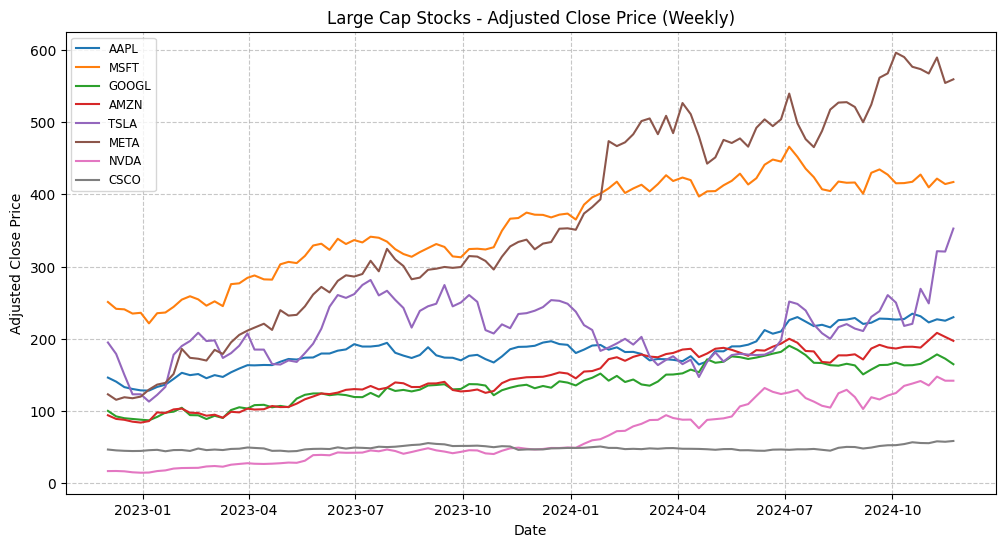

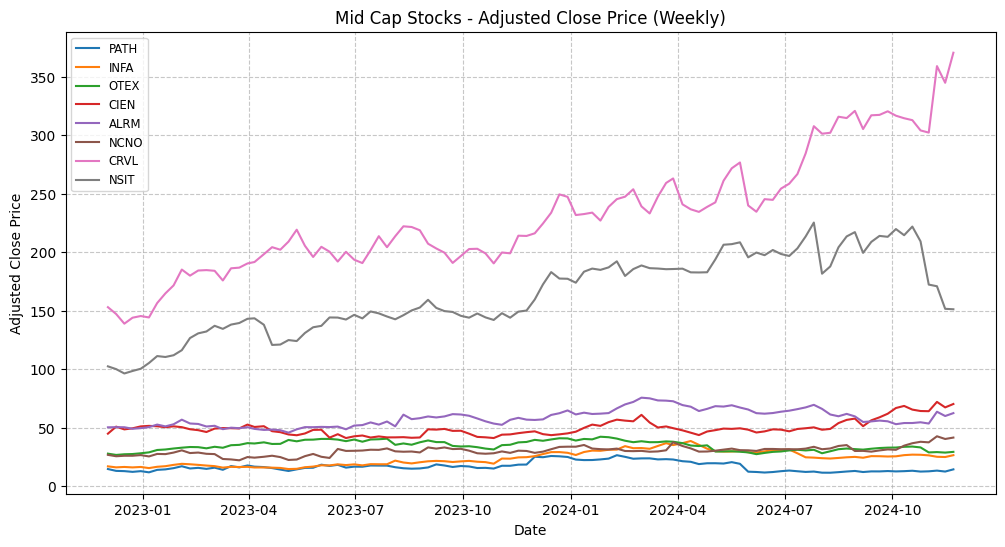

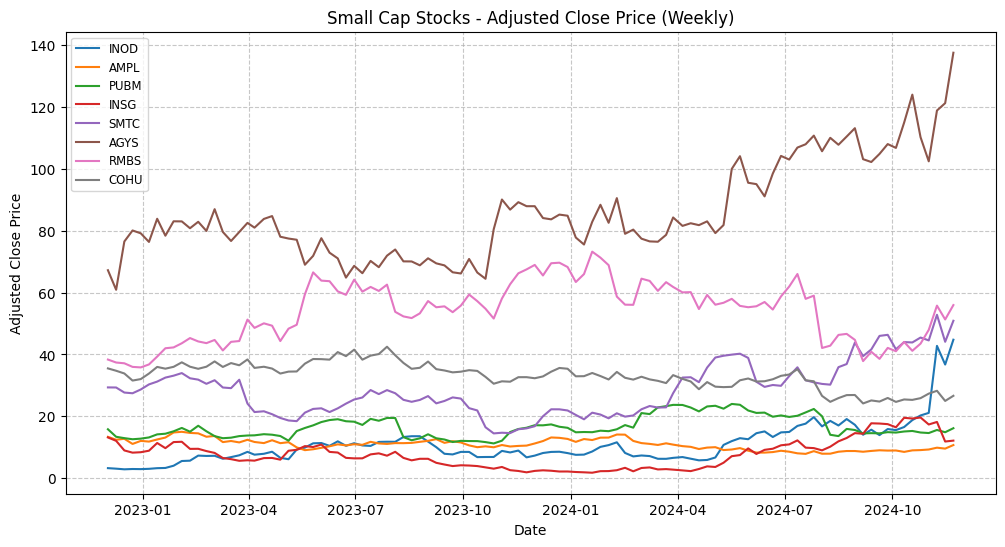

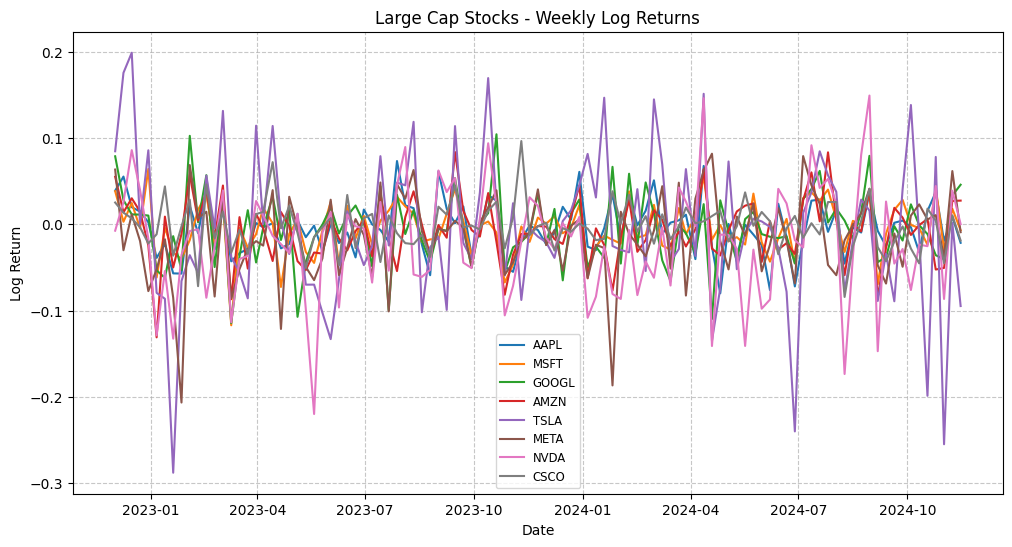

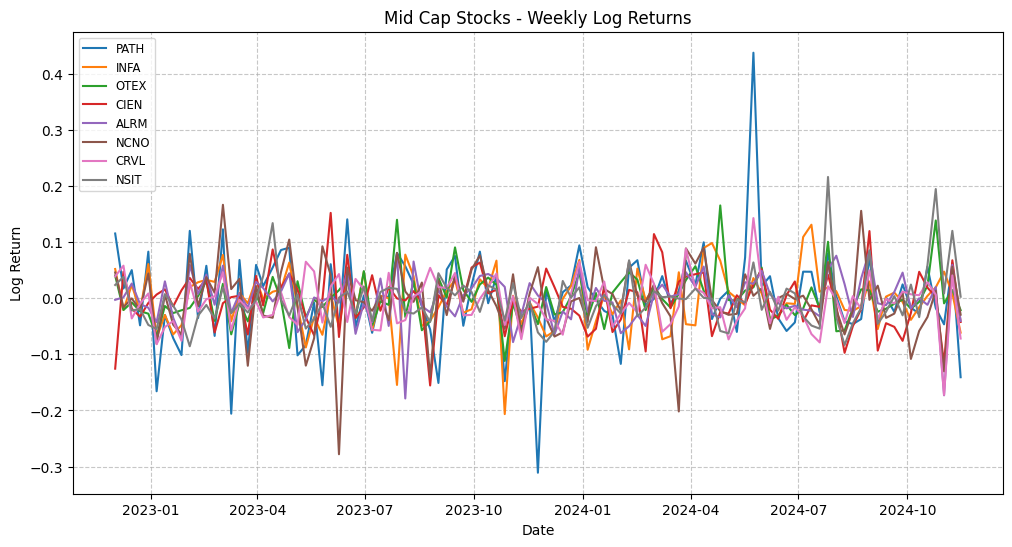

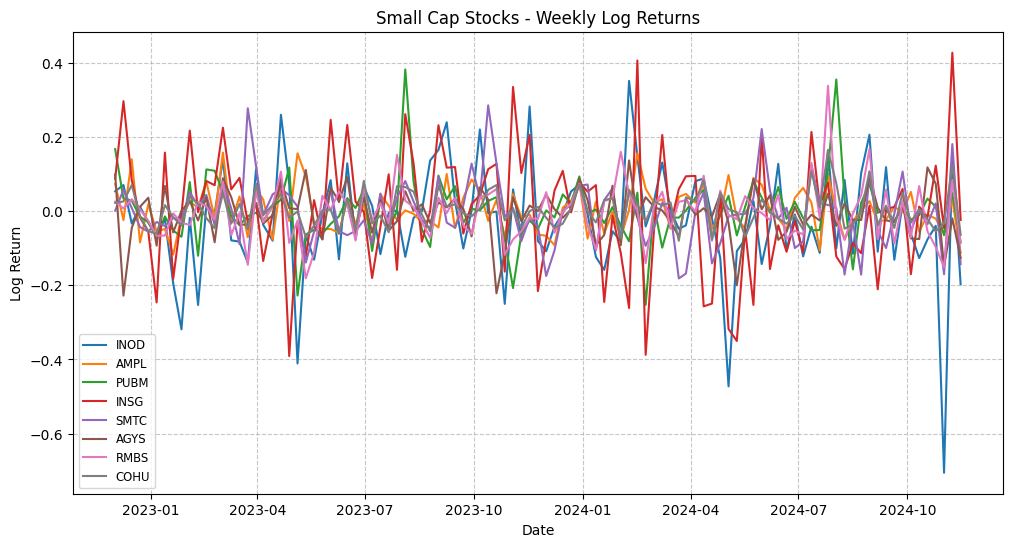

In [43]:
# Define stock tickers for each cap size
large_cap_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO']
mid_cap_stocks = ['PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT']
small_cap_stocks = ['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']

# Filter function to get stocks for a given cap size
def filter_by_cap(data, stock_list):
    """
    Filters the data to include only rows for the given stock list.

    Parameters:
        data (pd.DataFrame): DataFrame containing the stock data.
        stock_list (list): List of stock tickers to filter.

    Returns:
        pd.DataFrame: Filtered DataFrame containing only the specified stocks.
    """
    return data[data['Stock'].isin(stock_list)]

# Function to plot adjusted close price over time
def plot_adjusted_close(data, title):
    """
    Plots the adjusted close price for all stocks over time.

    Parameters:
        data (pd.DataFrame): DataFrame containing weekly data with 'date', 'Stock', and 'Adj Close'.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    for stock in data['Stock'].unique():
        stock_data = data[data['Stock'] == stock]
        plt.plot(stock_data['date'], stock_data['Adj Close'], label=stock)

    plt.title(title)
    plt.xlabel("Date")  # Display "Date" with uppercase "D"
    plt.ylabel("Adjusted Close Price")
    plt.legend(loc="best", fontsize="small")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Function to plot log returns over time
def plot_log_returns(data, title):
    """
    Plots the log returns for all stocks over time.

    Parameters:
        data (pd.DataFrame): DataFrame containing weekly data with 'date', 'Stock', and 'Log Return'.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    for stock in data['Stock'].unique():
        stock_data = data[data['Stock'] == stock]
        plt.plot(stock_data['date'], stock_data['Log Return'], label=stock)

    plt.title(title)
    plt.xlabel("Date")  # Display "Date" with uppercase "D"
    plt.ylabel("Log Return")
    plt.legend(loc="best", fontsize="small")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Filter data for each cap size
large_cap_data = filter_by_cap(all_weekly_log_returns, large_cap_stocks)
mid_cap_data = filter_by_cap(all_weekly_log_returns, mid_cap_stocks)
small_cap_data = filter_by_cap(all_weekly_log_returns, small_cap_stocks)

# Plot Adjusted Close Prices
plot_adjusted_close(large_cap_data, "Large Cap Stocks - Adjusted Close Price (Weekly)")
plot_adjusted_close(mid_cap_data, "Mid Cap Stocks - Adjusted Close Price (Weekly)")
plot_adjusted_close(small_cap_data, "Small Cap Stocks - Adjusted Close Price (Weekly)")

# Plot Weekly Log Returns
plot_log_returns(large_cap_data, "Large Cap Stocks - Weekly Log Returns")
plot_log_returns(mid_cap_data, "Mid Cap Stocks - Weekly Log Returns")
plot_log_returns(small_cap_data, "Small Cap Stocks - Weekly Log Returns")



## 5. Fetch Company Overview Data

In [45]:
# Function to fetch and process company overview data
def fetch_company_overview(stocks, fd):
    """
    Fetches company overview data from Alpha Vantage for a given list of stocks.

    Parameters:
        stocks (list): List of stock tickers to fetch data for.
        fd (FundamentalData): Initialized Alpha Vantage FundamentalData instance.

    Returns:
        pd.DataFrame: Combined DataFrame containing company overview data.
    """
    combined_overview = pd.DataFrame()  # Create an empty DataFrame to store combined data

    for stock in stocks:
        try:
            print(f"Fetching company overview for {stock}...")
            overview_data, _ = fd.get_company_overview(symbol=stock)  # Fetch data from Alpha Vantage
            if not overview_data.empty:  # Check if data is returned
                temp_df = overview_data.iloc[0].to_frame().T  # Transpose to make it a single-row DataFrame
                temp_df['Stock'] = stock  # Add stock symbol for identification
                combined_overview = pd.concat([combined_overview, temp_df], ignore_index=True)
            else:
                print(f"No data returned for {stock}.")
        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")

    # Set 'Stock' as the index of the combined DataFrame
    combined_overview.set_index('Stock', inplace=True)

    # Convert numerical data from strings to floats if necessary
    numerical_cols = ['MarketCap', 'Beta', 'PERatio', 'EPS', 'DividendYield', 
                      'DebtToEquity', 'ReturnOnEquityTTM', 'CurrentRatio']
    for col in numerical_cols:
        if col in combined_overview.columns:
            combined_overview[col] = pd.to_numeric(combined_overview[col], errors='coerce')

    return combined_overview


# List of stock tickers
all_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
              'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
              'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']

# Fetch company overview data
company_overview_data = fetch_company_overview(all_stocks, fd)

# Display the first 5 rows of the combined overview DataFrame
print("\nCompany Overview Data:")
print(company_overview_data.head())

# Save the combined DataFrame to a CSV file for group members to use
company_overview_data.to_csv("company_overview.csv")
print("\nCompany overview data saved to 'company_overview.csv'")

Fetching company overview for AAPL...
Fetching company overview for MSFT...
Fetching company overview for GOOGL...
Fetching company overview for AMZN...
Fetching company overview for TSLA...
Fetching company overview for META...
Fetching company overview for NVDA...
Fetching company overview for CSCO...
Fetching company overview for PATH...
Fetching company overview for INFA...
Fetching company overview for OTEX...
Fetching company overview for CIEN...
Fetching company overview for ALRM...
Fetching company overview for NCNO...
Fetching company overview for CRVL...
Fetching company overview for NSIT...
Fetching company overview for INOD...
Fetching company overview for AMPL...
Fetching company overview for PUBM...
Fetching company overview for INSG...
Fetching company overview for SMTC...
Fetching company overview for AGYS...
Fetching company overview for RMBS...
Fetching company overview for COHU...

Company Overview Data:
      Symbol     AssetType                   Name  \
Stock     

## 6.Create a Combined Overview

In [61]:
from alpha_vantage.fundamentaldata import FundamentalData
import pandas as pd

# Define stock tickers
stock_list = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
    'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
    'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'
]

# Read API key
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Fetch and combine company overview data
api_key = read_api_key('ApiKeys.txt')
fd = FundamentalData(key=api_key, output_format='pandas')
combined_overview = pd.DataFrame()

for stock in stock_list:
    try:
        data, _ = fd.get_company_overview(symbol=stock)
        temp_df = data.iloc[0].to_frame().T  # Transpose to make a single-row DataFrame
        temp_df['Stock'] = stock
        combined_overview = pd.concat([combined_overview, temp_df], ignore_index=True)
        print(f"Fetched data for {stock}")
    except Exception as e:
        print(f"Error fetching data for {stock}: {e}")

# Set 'Stock' as the index
combined_overview.set_index('Stock', inplace=True)

# Convert numerical columns
numerical_cols = ['Market Cap', 'Beta', 'P/E Ratio', 'EPS', 'Dividend Yield', 'Debt to Equity', 'ROE', 'Current Ratio']
for col in numerical_cols:
    if col in combined_overview.columns:
        combined_overview[col] = pd.to_numeric(combined_overview[col], errors='coerce')

# Display the first few rows
print(combined_overview.head())


Fetched data for AAPL
Fetched data for MSFT
Fetched data for GOOGL
Fetched data for AMZN
Fetched data for TSLA
Fetched data for META
Fetched data for NVDA
Fetched data for CSCO
Fetched data for PATH
Fetched data for INFA
Fetched data for OTEX
Fetched data for CIEN
Fetched data for ALRM
Fetched data for NCNO
Fetched data for CRVL
Fetched data for NSIT
Fetched data for INOD
Fetched data for AMPL
Fetched data for PUBM
Fetched data for INSG
Fetched data for SMTC
Fetched data for AGYS
Fetched data for RMBS
Fetched data for COHU
      Symbol     AssetType                   Name  \
Stock                                               
AAPL    AAPL  Common Stock              Apple Inc   
MSFT    MSFT  Common Stock  Microsoft Corporation   
GOOGL  GOOGL  Common Stock   Alphabet Inc Class A   
AMZN    AMZN  Common Stock         Amazon.com Inc   
TSLA    TSLA  Common Stock              Tesla Inc   

                                             Description      CIK Exchange  \
Stock                

In [63]:
combined_overview.head()

,Symbol,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,...,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
Stock,,,,,,,,,,,,,,,,,,,,,
AAPL,AAPL,Common Stock,Apple Inc,Apple Inc. is an American multinational techno...,320193,NASDAQ,USD,USA,TECHNOLOGY,ELECTRONIC COMPUTERS,...,9.19,26.68,1.240,237.81,163.49,228.72,205.56,15115800000,2024-11-14,2024-11-08
MSFT,MSFT,Common Stock,Microsoft Corporation,Microsoft Corporation is an American multinati...,789019,NASDAQ,USD,USA,TECHNOLOGY,SERVICES-PREPACKAGED SOFTWARE,...,12.31,22.42,0.904,466.57,360.21,421.36,421.96,7434880000,2024-12-12,2024-11-21
GOOGL,GOOGL,Common Stock,Alphabet Inc Class A,Alphabet Inc. is an American multinational con...,1652044,NASDAQ,USD,USA,TECHNOLOGY,"SERVICES-COMPUTER PROGRAMMING, DATA PROCESSING...",...,5.93,15.9,1.034,191.5,127.58,168.21,164.32,5843000000,2024-12-16,2024-12-09
AMZN,AMZN,Common Stock,Amazon.com Inc,"Amazon.com, Inc. is an American multinational ...",1018724,NASDAQ,USD,USA,TRADE & SERVICES,RETAIL-CATALOG & MAIL-ORDER HOUSES,...,3.564,19.47,1.146,215.9,142.81,194.13,184.3,10515000000,None,None
TSLA,TSLA,Common Stock,Tesla Inc,"Tesla, Inc. is an American electric vehicle an...",1318605,NASDAQ,USD,USA,MANUFACTURING,MOTOR VEHICLES & PASSENGER CAR BODIES,...,11.19,78.58,2.295,361.93,138.8,270.62,214.05,3210060000,None,None


## 7. Sentiment Analysis

In [27]:
import requests
import pandas as pd

# Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Read API key
api_key = read_api_key('ApiKeys.txt')

# Define base URL
base_url = 'https://www.alphavantage.co/query'

# Define the list of tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
    'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
    'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'
]

# Define timeframe
time_from = '20231127T0000'  # Start date: November 27, 2023
time_to = '20241127T0000'    # End date: November 27, 2024

# List to store all articles
all_articles = []

# Fetch articles for each ticker with technology filter
for ticker in tickers:
    print(f"Fetching technology articles for {ticker}...")
    params = {
        'function': 'NEWS_SENTIMENT',
        'apikey': api_key,
        'tickers': ticker,
        'time_from': time_from,
        'time_to': time_to,
        'limit': 1000,  # Set limit to 1000
        'topics': 'technology'  # Add technology filter
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "feed" in data and data["feed"]:
            print(f"Found {len(data['feed'])} technology articles for {ticker}.")
            # Add ticker info to each article
            for article in data["feed"]:
                article["Ticker"] = ticker
            all_articles.extend(data["feed"])
        else:
            print(f"No technology articles found for {ticker}.")
    else:
        print(f"Error fetching data for {ticker}: {response.status_code}, {response.text}")

# Combine all articles into a DataFrame
if all_articles:
    articles_df = pd.DataFrame(all_articles)

    # Save to CSV
    articles_df.to_csv("technology_news_sentiment_data.csv", index=False)
    print(f"All technology articles saved to 'technology_news_sentiment_data.csv'. Total articles: {len(all_articles)}")
else:
    print("No technology articles were retrieved for any ticker.")

Fetching technology articles for AAPL...
Found 680 technology articles for AAPL.
Fetching technology articles for MSFT...
Found 694 technology articles for MSFT.
Fetching technology articles for GOOGL...
No technology articles found for GOOGL.
Fetching technology articles for AMZN...
No technology articles found for AMZN.
Fetching technology articles for TSLA...
No technology articles found for TSLA.
Fetching technology articles for META...
Found 674 technology articles for META.
Fetching technology articles for NVDA...
No technology articles found for NVDA.
Fetching technology articles for CSCO...
Found 673 technology articles for CSCO.
Fetching technology articles for PATH...
Found 694 technology articles for PATH.
Fetching technology articles for INFA...
Found 129 technology articles for INFA.
Fetching technology articles for OTEX...
Found 68 technology articles for OTEX.
Fetching technology articles for CIEN...
No technology articles found for CIEN.
Fetching technology articles for

In [38]:
import requests
import pandas as pd

# Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Read API key
api_key = read_api_key('ApiKeys.txt')

# Define base URL
base_url = 'https://www.alphavantage.co/query'

# Define the list of tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
    'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
    'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'
]

# Define timeframe
time_from = '20231127T0000'  # Start date: November 27, 2023
time_to = '20241127T0000'    # End date: November 27, 2024

# List to store all articles
all_articles = []

# Fetch articles for each ticker with an increased limit
for ticker in tickers:
    print(f"Fetching articles for {ticker}...")
    params = {
        'function': 'NEWS_SENTIMENT',
        'apikey': api_key,
        'tickers': ticker,
        'time_from': time_from,
        'time_to': time_to,
        'limit': 1000  # Set limit to 1000
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "feed" in data and data["feed"]:
            print(f"Found {len(data['feed'])} articles for {ticker}.")
            # Add ticker info to each article
            for article in data["feed"]:
                article["Ticker"] = ticker
            all_articles.extend(data["feed"])
        else:
            print(f"No articles found for {ticker}.")
    else:
        print(f"Error fetching data for {ticker}: {response.status_code}, {response.text}")

# Combine all articles into a DataFrame
if all_articles:
    articles_df = pd.DataFrame(all_articles)

    # Save to CSV
    articles_df.to_csv("news_sentiment_data_full_timeframe.csv", index=False)
    print(f"All articles saved to 'news_sentiment_data_full_timeframe.csv'. Total articles: {len(all_articles)}")
else:
    print("No articles were retrieved for any ticker.")


Fetching articles for AAPL...
Found 689 articles for AAPL.
Fetching articles for MSFT...
Found 703 articles for MSFT.
Fetching articles for GOOGL...
No articles found for GOOGL.
Fetching articles for AMZN...
Found 717 articles for AMZN.
Fetching articles for TSLA...
Found 675 articles for TSLA.
Fetching articles for META...
Found 681 articles for META.
Fetching articles for NVDA...
Found 704 articles for NVDA.
Fetching articles for CSCO...
Found 681 articles for CSCO.
Fetching articles for PATH...
Found 694 articles for PATH.
Fetching articles for INFA...
Found 129 articles for INFA.
Fetching articles for OTEX...
Found 68 articles for OTEX.
Fetching articles for CIEN...
Found 129 articles for CIEN.
Fetching articles for ALRM...
No articles found for ALRM.
Fetching articles for NCNO...
Found 119 articles for NCNO.
Fetching articles for CRVL...
Found 32 articles for CRVL.
Fetching articles for NSIT...
Found 76 articles for NSIT.
Fetching articles for INOD...
Found 184 articles for INOD.


In [42]:
import pandas as pd

# Load the dataset
df = pd.read_csv("news_sentiment_data_full_timeframe.csv")

# Display basic information
print(df.info())

# Check the first few rows
print(df.head())

# Check the unique tickers and article counts
print("Articles per ticker:")
print(df['Ticker'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6953 entries, 0 to 6952
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    6953 non-null   object 
 1   url                      6953 non-null   object 
 2   time_published           6953 non-null   object 
 3   authors                  6953 non-null   object 
 4   summary                  6953 non-null   object 
 5   banner_image             6749 non-null   object 
 6   source                   6953 non-null   object 
 7   category_within_source   2954 non-null   object 
 8   source_domain            6953 non-null   object 
 9   topics                   6953 non-null   object 
 10  overall_sentiment_score  6953 non-null   float64
 11  overall_sentiment_label  6953 non-null   object 
 12  ticker_sentiment         6953 non-null   object 
 13  Ticker                   6953 non-null   object 
dtypes: float64(1), object(13

In [44]:
# Sentiment distribution across all tickers
sentiment_counts = df['overall_sentiment_label'].value_counts()
print("Overall Sentiment Distribution:")
print(sentiment_counts)

# Sentiment distribution per ticker
ticker_sentiment = df.groupby('Ticker')['overall_sentiment_label'].value_counts()
print("Sentiment Distribution by Ticker:")
print(ticker_sentiment)


Overall Sentiment Distribution:
overall_sentiment_label
Somewhat-Bullish    4187
Neutral             1828
Bullish              858
Somewhat-Bearish      44
Bearish               36
Name: count, dtype: int64
Sentiment Distribution by Ticker:
Ticker  overall_sentiment_label
AAPL    Somewhat-Bullish           466
        Neutral                    166
        Bullish                     51
        Somewhat-Bearish             4
        Bearish                      2
                                  ... 
SMTC    Bullish                     12
TSLA    Somewhat-Bullish           399
        Neutral                    213
        Bullish                     58
        Somewhat-Bearish             5
Name: count, Length: 81, dtype: int64


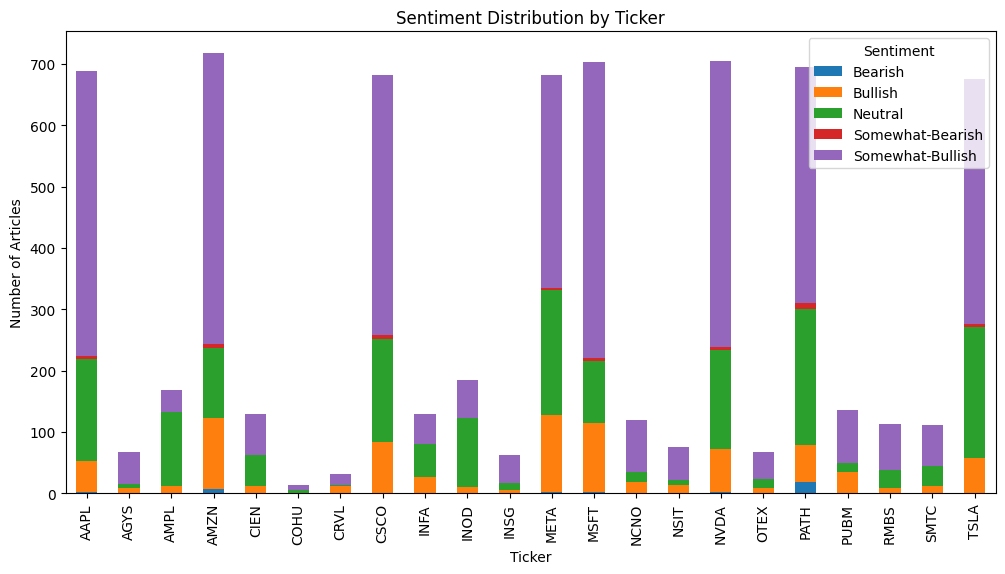

In [46]:
import matplotlib.pyplot as plt

# Sentiment distribution by ticker
sentiment_counts_by_ticker = df.groupby(['Ticker', 'overall_sentiment_label']).size().unstack()

# Plot
sentiment_counts_by_ticker.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Sentiment Distribution by Ticker")
plt.xlabel("Ticker")
plt.ylabel("Number of Articles")
plt.legend(title="Sentiment")
plt.show()


## 8. Combine Sentiment & Daily Log Returns 

In [7]:
import pandas as pd

# Load sentiment data
sentiment_data = pd.read_csv("news_sentiment_data_full_timeframe.csv")

# Extract date from time_published and convert to datetime
sentiment_data['date'] = pd.to_datetime(sentiment_data['time_published'].str[:8])

# Aggregate sentiment by date and ticker (e.g., average sentiment score)
aggregated_sentiment = sentiment_data.groupby(['date', 'Ticker'])['overall_sentiment_score'].mean().reset_index()
print(aggregated_sentiment.head())

        date Ticker  overall_sentiment_score
0 2023-11-27   AMPL                 0.140470
1 2023-11-27   CIEN                 0.275286
2 2023-11-27   NCNO                 0.297856
3 2023-11-27   PATH                 0.308800
4 2023-11-28   AGYS                 0.266368


In [52]:
# Load stock return data
stock_returns = pd.read_csv("daily_log_returns.csv")  # Replace with your file
stock_returns['date'] = pd.to_datetime(stock_returns['date'])
print(stock_returns.head())


        date    Open      High       Low   Close  Adj Close      Volume  \
0 2024-11-26  233.33  235.5700  233.3300  235.06     235.06  45986189.0   
1 2024-11-25  231.46  233.2450  229.7400  232.87     232.87  90152832.0   
2 2024-11-22  228.06  230.7199  228.0600  229.87     229.87  38168252.0   
3 2024-11-21  228.88  230.1550  225.7103  228.52     228.52  42108327.0   
4 2024-11-20  228.06  229.9300  225.8900  229.00     229.00  35169566.0   

   Dividend  Split Coefficient Stock  Log Return  
0       0.0                1.0  AAPL         NaN  
1       0.0                1.0  AAPL   -0.009360  
2       0.0                1.0  AAPL   -0.012966  
3       0.0                1.0  AAPL   -0.005890  
4       0.0                1.0  AAPL    0.002098  


In [56]:
# Ensure 'date' is formatted consistently in both datasets
sentiment_data['date'] = pd.to_datetime(sentiment_data['time_published'].str[:8])
stock_returns['date'] = pd.to_datetime(stock_returns['date'])

# Merge sentiment data with stock returns
merged_data = pd.merge(
    stock_returns,
    sentiment_data.groupby(['date', 'Ticker'])['overall_sentiment_score'].mean().reset_index(),
    left_on=['date', 'Stock'],   # 'Stock' is the column in stock_returns
    right_on=['date', 'Ticker'], # 'Ticker' is the column in sentiment_data
    how='inner'                  # Merge only matching rows
)

# Display the merged dataset
print(merged_data.head())

        date    Open      High       Low   Close  Adj Close      Volume  \
0 2024-11-26  233.33  235.5700  233.3300  235.06     235.06  45986189.0   
1 2024-11-25  231.46  233.2450  229.7400  232.87     232.87  90152832.0   
2 2024-11-22  228.06  230.7199  228.0600  229.87     229.87  38168252.0   
3 2024-11-21  228.88  230.1550  225.7103  228.52     228.52  42108327.0   
4 2024-11-20  228.06  229.9300  225.8900  229.00     229.00  35169566.0   

   Dividend  Split Coefficient Stock  Log Return Ticker  \
0       0.0                1.0  AAPL         NaN   AAPL   
1       0.0                1.0  AAPL   -0.009360   AAPL   
2       0.0                1.0  AAPL   -0.012966   AAPL   
3       0.0                1.0  AAPL   -0.005890   AAPL   
4       0.0                1.0  AAPL    0.002098   AAPL   

   overall_sentiment_score  
0                 0.167470  
1                 0.234979  
2                 0.153672  
3                 0.195614  
4                 0.164971  


In [58]:
# Correlation analysis
correlation = merged_data[['Log Return', 'overall_sentiment_score']].corr()
print("Correlation between Sentiment Score and Daily Log Return:")
print(correlation)

Correlation between Sentiment Score and Daily Log Return:
                         Log Return  overall_sentiment_score
Log Return                 1.000000                -0.012818
overall_sentiment_score   -0.012818                 1.000000


## 9. Group Data By Market Cap for Sentiment and Introduce Lag Periods

In [64]:
# Example: Filter for small-cap stocks
small_cap_data = merged_data[merged_data['Ticker'].isin(['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'])]

# Calculate correlation for small caps
small_cap_corr = small_cap_data[['Log Return', 'overall_sentiment_score']].corr()
print("Small-Cap Correlation:")
print(small_cap_corr)

Small-Cap Correlation:
                         Log Return  overall_sentiment_score
Log Return                 1.000000                -0.013941
overall_sentiment_score   -0.013941                 1.000000


In [66]:
# Add article count as a feature
aggregated_sentiment = sentiment_data.groupby(['date', 'Ticker']).agg(
    sentiment_score=('overall_sentiment_score', 'mean'),
    article_count=('overall_sentiment_score', 'size')
).reset_index()

# Merge with stock returns
merged_data = pd.merge(
    stock_returns,
    aggregated_sentiment,
    left_on=['date', 'Stock'],
    right_on=['date', 'Ticker'],
    how='inner'
)

# Correlation including article count
correlation_with_count = merged_data[['Log Return', 'sentiment_score', 'article_count']].corr()
print("Correlation with Article Count:")
print(correlation_with_count)

Correlation with Article Count:
                 Log Return  sentiment_score  article_count
Log Return         1.000000        -0.012818      -0.005221
sentiment_score   -0.012818         1.000000      -0.016687
article_count     -0.005221        -0.016687       1.000000


In [68]:
# Add lagged returns
merged_data['Lagged Return'] = merged_data['Log Return'].shift(-1)

# Correlation with lagged return
lagged_corr = merged_data[['Lagged Return', 'sentiment_score']].corr()
print("Correlation with Lagged Return:")
print(lagged_corr)

Correlation with Lagged Return:
                 Lagged Return  sentiment_score
Lagged Return         1.000000        -0.070985
sentiment_score      -0.070985         1.000000


In [9]:
import pandas
# Load the sentiment data
sentiment_data = pd.read_csv("news_sentiment_data_full_timeframe.csv")

# Extract and format the date from `time_published`
sentiment_data['date'] = pd.to_datetime(sentiment_data['time_published'].str[:8], format='%Y%m%d')

# Align the extracted dates to week-ending (Friday)
sentiment_data['date'] = sentiment_data['date'].dt.to_period('W-FRI').dt.end_time

# Aggregate sentiment scores and article counts
aggregated_sentiment = sentiment_data.groupby(['date', 'Ticker']).agg({
    'overall_sentiment_score': 'mean',  # Average sentiment score
    'time_published': 'count'          # Count of articles
}).reset_index()

# Rename columns for clarity
aggregated_sentiment = aggregated_sentiment.rename(columns={'time_published': 'article_count'})

# Display the processed sentiment data
print("Aggregated Sentiment Data:")
print(aggregated_sentiment.head())

Aggregated Sentiment Data:
                           date Ticker  overall_sentiment_score  article_count
0 2023-12-01 23:59:59.999999999   AGYS                 0.266368              1
1 2023-12-01 23:59:59.999999999   AMPL                 0.140470              1
2 2023-12-01 23:59:59.999999999   CIEN                 0.299845              2
3 2023-12-01 23:59:59.999999999   INFA                 0.066461              2
4 2023-12-01 23:59:59.999999999   INOD                 0.244579              1


In [15]:
import pandas as pd

# Reload the weekly returns data
weekly_returns = pd.read_csv('weekly_log_returns.csv')

# Ensure the 'date' column is in datetime format
weekly_returns['date'] = pd.to_datetime(weekly_returns['date'])

# Rename 'Stock' to 'Ticker' for consistency
if 'Stock' in weekly_returns.columns:
    weekly_returns = weekly_returns.rename(columns={"Stock": "Ticker"})

# Display the first few rows to confirm it is loaded
print("Weekly Returns Data:")
print(weekly_returns.head())

Weekly Returns Data:
        date    Open      High     Low   Close  Adj Close       Volume  \
0 2024-11-22  225.25  230.7199  225.17  229.87   229.8700  196343939.0   
1 2024-11-15  225.00  228.8700  221.50  225.00   225.0000  223817755.0   
2 2024-11-08  220.99  228.6600  219.71  226.96   226.9600  208083442.0   
3 2024-11-01  233.32  234.7300  220.27  222.91   222.6647  248222115.0   
4 2024-10-25  234.45  236.8500  227.76  231.41   231.1554  197299834.0   

   7. dividend amount Ticker  Log Return  
0                0.00   AAPL         NaN  
1                0.00   AAPL   -0.021414  
2                0.25   AAPL    0.008673  
3                0.00   AAPL   -0.019107  
4                0.00   AAPL    0.037423  


In [17]:
# Load the sentiment data
sentiment_data = pd.read_csv("news_sentiment_data_full_timeframe.csv")

# Extract and format the date from `time_published`
sentiment_data['date'] = pd.to_datetime(sentiment_data['time_published'].str[:8], format='%Y%m%d')

# Align the extracted dates to week-ending (Friday)
sentiment_data['date'] = sentiment_data['date'].dt.to_period('W-FRI').dt.end_time

# Aggregate sentiment scores and article counts
aggregated_sentiment = sentiment_data.groupby(['date', 'Ticker']).agg({
    'overall_sentiment_score': 'mean',
    'time_published': 'count'
}).reset_index()

# Rename columns for clarity
aggregated_sentiment = aggregated_sentiment.rename(columns={'time_published': 'article_count'})

# Display the aggregated sentiment data
print("Aggregated Sentiment Data:")
print(aggregated_sentiment.head())

Aggregated Sentiment Data:
                           date Ticker  overall_sentiment_score  article_count
0 2023-12-01 23:59:59.999999999   AGYS                 0.266368              1
1 2023-12-01 23:59:59.999999999   AMPL                 0.140470              1
2 2023-12-01 23:59:59.999999999   CIEN                 0.299845              2
3 2023-12-01 23:59:59.999999999   INFA                 0.066461              2
4 2023-12-01 23:59:59.999999999   INOD                 0.244579              1


In [19]:
# Normalize 'date' in weekly_returns to remove time
weekly_returns['date'] = weekly_returns['date'].dt.normalize()

# Normalize 'date' in aggregated_sentiment to remove time
aggregated_sentiment['date'] = aggregated_sentiment['date'].dt.normalize()

In [21]:
# Merge the datasets
merged_weekly_data = pd.merge(
    weekly_returns,
    aggregated_sentiment,
    on=['date', 'Ticker'],  # Match by date and ticker
    how='inner'             # Keep only matching rows
)

# Display the merged data
print("Merged Weekly Data:")
print(merged_weekly_data.head())

Merged Weekly Data:
        date    Open      High     Low   Close  Adj Close       Volume  \
0 2024-11-22  225.25  230.7199  225.17  229.87   229.8700  196343939.0   
1 2024-11-15  225.00  228.8700  221.50  225.00   225.0000  223817755.0   
2 2024-11-08  220.99  228.6600  219.71  226.96   226.9600  208083442.0   
3 2024-11-01  233.32  234.7300  220.27  222.91   222.6647  248222115.0   
4 2024-10-25  234.45  236.8500  227.76  231.41   231.1554  197299834.0   

   7. dividend amount Ticker  Log Return  overall_sentiment_score  \
0                0.00   AAPL         NaN                 0.195212   
1                0.00   AAPL   -0.021414                 0.208010   
2                0.25   AAPL    0.008673                 0.217604   
3                0.00   AAPL   -0.019107                 0.210266   
4                0.00   AAPL    0.037423                 0.206494   

   article_count  
0             88  
1            101  
2            116  
3            144  
4            121  


In [23]:
# Check size of the merged dataset
print(f"Merged Dataset Size: {merged_weekly_data.shape[0]} rows")

# Display a sample
print("Sample of Merged Weekly Data:")
print(merged_weekly_data.head())


Merged Dataset Size: 547 rows
Sample of Merged Weekly Data:
        date    Open      High     Low   Close  Adj Close       Volume  \
0 2024-11-22  225.25  230.7199  225.17  229.87   229.8700  196343939.0   
1 2024-11-15  225.00  228.8700  221.50  225.00   225.0000  223817755.0   
2 2024-11-08  220.99  228.6600  219.71  226.96   226.9600  208083442.0   
3 2024-11-01  233.32  234.7300  220.27  222.91   222.6647  248222115.0   
4 2024-10-25  234.45  236.8500  227.76  231.41   231.1554  197299834.0   

   7. dividend amount Ticker  Log Return  overall_sentiment_score  \
0                0.00   AAPL         NaN                 0.195212   
1                0.00   AAPL   -0.021414                 0.208010   
2                0.25   AAPL    0.008673                 0.217604   
3                0.00   AAPL   -0.019107                 0.210266   
4                0.00   AAPL    0.037423                 0.206494   

   article_count  
0             88  
1            101  
2            116  
3   

In [25]:
# Correlation analysis
correlation_matrix = merged_weekly_data[['Log Return', 'overall_sentiment_score', 'article_count']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                         Log Return  overall_sentiment_score  article_count
Log Return                 1.000000                -0.072128       0.011439
overall_sentiment_score   -0.072128                 1.000000      -0.076102
article_count              0.011439                -0.076102       1.000000


In [167]:
# Shift sentiment scores and article counts by 1 week
merged_weekly_data['Lagged Sentiment Score'] = merged_weekly_data.groupby('Ticker')['overall_sentiment_score'].shift(2)
merged_weekly_data['Lagged Article Count'] = merged_weekly_data.groupby('Ticker')['article_count'].shift(2)

# Drop rows with NaN values caused by the lagging operation
lagged_weekly_data = merged_weekly_data.dropna(subset=['Lagged Sentiment Score', 'Lagged Article Count'])

# Compute correlation matrix with lagged sentiment
correlation_matrix_lagged = lagged_weekly_data[['Log Return', 'Lagged Sentiment Score', 'Lagged Article Count']].corr()

# Display results
print("Lagged Correlation Matrix:")
print(correlation_matrix_lagged)

Lagged Correlation Matrix:
                        Log Return  Lagged Sentiment Score  \
Log Return                1.000000               -0.148038   
Lagged Sentiment Score   -0.148038                1.000000   
Lagged Article Count      0.030096               -0.117912   

                        Lagged Article Count  
Log Return                          0.030096  
Lagged Sentiment Score             -0.117912  
Lagged Article Count                1.000000  


In [65]:
# Filter for small-cap stocks (base case: no lag)
small_cap_stocks = ['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']
small_cap_base_data = merged_weekly_data[merged_weekly_data['Ticker'].isin(small_cap_stocks)]

# Compute correlation matrix for small caps (base case)
correlation_matrix_small_cap_base = small_cap_base_data[['Log Return', 'overall_sentiment_score', 'article_count']].corr()

# Display results
print("Base Case Correlation Matrix for Small-Cap Stocks (No Lag):")
print(correlation_matrix_small_cap_base)

Base Case Correlation Matrix for Small-Cap Stocks (No Lag):
                         Log Return  overall_sentiment_score  article_count
Log Return                 1.000000                -0.076295       0.105743
overall_sentiment_score   -0.076295                 1.000000      -0.420312
article_count              0.105743                -0.420312       1.000000


In [39]:
# Define small-cap stock tickers
small_cap_stocks = ['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']

# Filter for small-cap stocks
small_cap_data = merged_weekly_data[merged_weekly_data['Ticker'].isin(small_cap_stocks)]

In [63]:
import pandas as pd

# Define small-cap stock tickers
small_cap_stocks = ['INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU']

# Filter for small-cap stocks
small_cap_data = merged_weekly_data[merged_weekly_data['Ticker'].isin(small_cap_stocks)].copy()

# Introduce a 1-week lag for sentiment score and article count
small_cap_data['Lagged Sentiment Score (1 Week)'] = small_cap_data.groupby('Ticker')['overall_sentiment_score'].shift(1)
small_cap_data['Lagged Article Count (1 Week)'] = small_cap_data.groupby('Ticker')['article_count'].shift(1)

# Drop rows with NaN values introduced by the lag
small_cap_data_lagged = small_cap_data.dropna(subset=['Lagged Sentiment Score (1 Week)', 'Lagged Article Count (1 Week)', 'Log Return'])

# Calculate the correlation matrix for 1-week lag
correlation_matrix_small_cap = small_cap_data_lagged[['Log Return', 'Lagged Sentiment Score (1 Week)', 'Lagged Article Count (1 Week)']].corr()

# Display results
print("Small-Cap Correlation Matrix (1 Week):")
print(correlation_matrix_small_cap)

Small-Cap Correlation Matrix (1 Week):
                                 Log Return  Lagged Sentiment Score (1 Week)  \
Log Return                         1.000000                        -0.087670   
Lagged Sentiment Score (1 Week)   -0.087670                         1.000000   
Lagged Article Count (1 Week)      0.142204                        -0.423251   

                                 Lagged Article Count (1 Week)  
Log Return                                            0.142204  
Lagged Sentiment Score (1 Week)                      -0.423251  
Lagged Article Count (1 Week)                         1.000000  


In [43]:
# Introduce a 2-week lag
small_cap_data.loc[:, 'Lagged Sentiment Score (2 Weeks)'] = small_cap_data.groupby('Ticker')['overall_sentiment_score'].shift(2)
small_cap_data.loc[:, 'Lagged Article Count (2 Weeks)'] = small_cap_data.groupby('Ticker')['article_count'].shift(2)

# Introduce a 3-week lag
small_cap_data.loc[:, 'Lagged Sentiment Score (3 Weeks)'] = small_cap_data.groupby('Ticker')['overall_sentiment_score'].shift(3)
small_cap_data.loc[:, 'Lagged Article Count (3 Weeks)'] = small_cap_data.groupby('Ticker')['article_count'].shift(3)


In [45]:
# Compute correlation matrices for 2-week and 3-week lags
correlation_matrix_small_cap_2_weeks = lagged_small_cap_2_weeks[['Log Return', 'Lagged Sentiment Score (2 Weeks)', 'Lagged Article Count (2 Weeks)']].corr()
correlation_matrix_small_cap_3_weeks = lagged_small_cap_3_weeks[['Log Return', 'Lagged Sentiment Score (3 Weeks)', 'Lagged Article Count (3 Weeks)']].corr()

# Display results
print("Small-Cap Correlation Matrix (2 Weeks):")
print(correlation_matrix_small_cap_2_weeks)

print("\nSmall-Cap Correlation Matrix (3 Weeks):")
print(correlation_matrix_small_cap_3_weeks)


Small-Cap Correlation Matrix (2 Weeks):
                                  Log Return  \
Log Return                          1.000000   
Lagged Sentiment Score (2 Weeks)   -0.178177   
Lagged Article Count (2 Weeks)      0.076210   

                                  Lagged Sentiment Score (2 Weeks)  \
Log Return                                               -0.178177   
Lagged Sentiment Score (2 Weeks)                          1.000000   
Lagged Article Count (2 Weeks)                           -0.452629   

                                  Lagged Article Count (2 Weeks)  
Log Return                                              0.076210  
Lagged Sentiment Score (2 Weeks)                       -0.452629  
Lagged Article Count (2 Weeks)                          1.000000  

Small-Cap Correlation Matrix (3 Weeks):
                                  Log Return  \
Log Return                          1.000000   
Lagged Sentiment Score (3 Weeks)   -0.097636   
Lagged Article Count (3 Weeks)   

In [67]:
# Base case for mid-cap and large-cap stocks without lag
for data, label in [(mid_cap_data, 'Mid-Cap'), (large_cap_data, 'Large-Cap')]:
    data = data.copy()  # Ensure we're working with a copy

    # Compute correlation matrix using the original sentiment scores and article counts (no lagging)
    correlation_matrix = data[['Log Return', 'overall_sentiment_score', 'article_count']].corr()

    # Display results
    print(f"{label} Correlation Matrix (Base Case - No Lag):")
    print(correlation_matrix)
    print("\n")

Mid-Cap Correlation Matrix (Base Case - No Lag):
                         Log Return  overall_sentiment_score  article_count
Log Return                 1.000000                -0.093111       0.115794
overall_sentiment_score   -0.093111                 1.000000      -0.319094
article_count              0.115794                -0.319094       1.000000


Large-Cap Correlation Matrix (Base Case - No Lag):
                         Log Return  overall_sentiment_score  article_count
Log Return                 1.000000                 0.296169      -0.047916
overall_sentiment_score    0.296169                 1.000000      -0.104145
article_count             -0.047916                -0.104145       1.000000




In [171]:
# Introduce a 2-week lag for mid-cap and large-cap stocks without warnings
for data, label in [(mid_cap_data, 'Mid-Cap'), (large_cap_data, 'Large-Cap')]:
    data = data.copy()  # Ensure we're working with a copy to avoid warnings
    data['Lagged Sentiment Score (2 Weeks)'] = data.groupby('Ticker')['overall_sentiment_score'].shift(3)
    data['Lagged Article Count (2 Weeks)'] = data.groupby('Ticker')['article_count'].shift(3)

    # Drop rows with NaN values caused by the lagging operation
    lagged_data = data.dropna(subset=['Lagged Sentiment Score (2 Weeks)', 'Lagged Article Count (2 Weeks)'])

    # Compute correlation matrix
    correlation_matrix = lagged_data[['Log Return', 'Lagged Sentiment Score (2 Weeks)', 'Lagged Article Count (2 Weeks)']].corr()

    # Display results
    print(f"{label} Correlation Matrix (2 Weeks):")
    print(correlation_matrix)
    print("\n")

Mid-Cap Correlation Matrix (2 Weeks):
                                  Log Return  \
Log Return                               NaN   
Lagged Sentiment Score (2 Weeks)         NaN   
Lagged Article Count (2 Weeks)           NaN   

                                  Lagged Sentiment Score (2 Weeks)  \
Log Return                                                     NaN   
Lagged Sentiment Score (2 Weeks)                               NaN   
Lagged Article Count (2 Weeks)                                 NaN   

                                  Lagged Article Count (2 Weeks)  
Log Return                                                   NaN  
Lagged Sentiment Score (2 Weeks)                             NaN  
Lagged Article Count (2 Weeks)                               NaN  


Large-Cap Correlation Matrix (2 Weeks):
                                  Log Return  \
Log Return                          1.000000   
Lagged Sentiment Score (2 Weeks)   -0.045209   
Lagged Article Count (2 Weeks)    

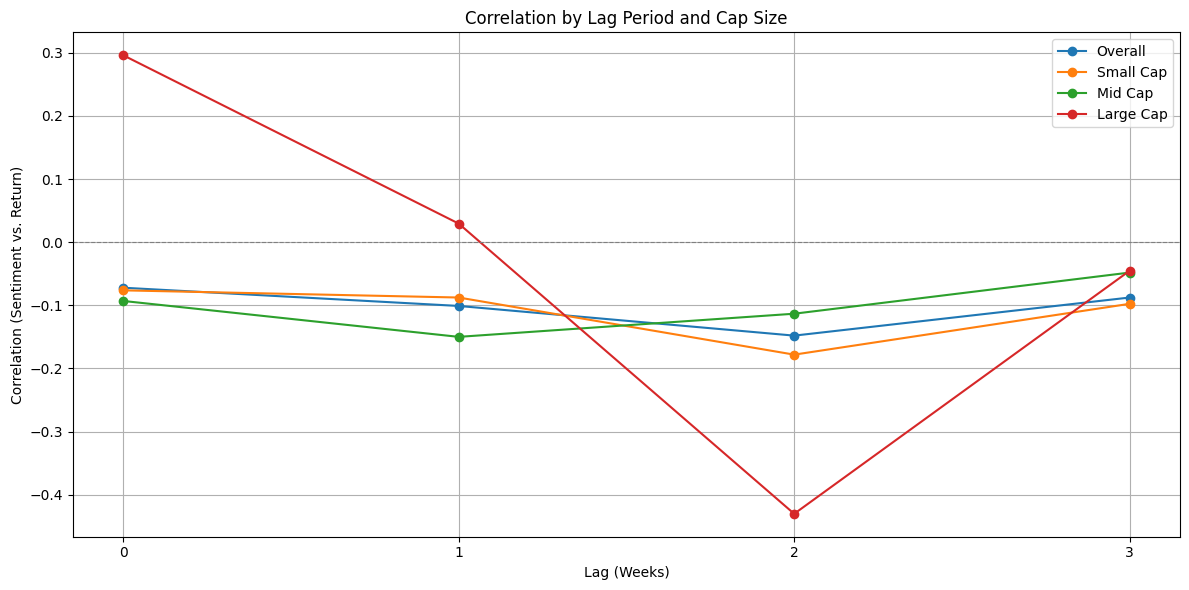

In [77]:
import matplotlib.pyplot as plt

# Define the lag periods (including 0 for no lag)
lag_periods = [0, 1, 2, 3]

# Correlation values for each cap size (replace these with your actual results)
correlations_overall = [-0.072128 , -0.101024, -0.148038, -0.087670]
correlations_small_cap = [-0.076295, -0.087670, -0.178177, -0.097636]
correlations_mid_cap = [-0.093111,-0.149992 , -0.113330, -0.048126]
correlations_large_cap = [0.296169, 0.029444 ,  -0.430331, -0.045209]

# Plotting correlations by lag period
plt.figure(figsize=(12, 6))

plt.plot(lag_periods, correlations_overall, marker='o', label='Overall')
plt.plot(lag_periods, correlations_small_cap, marker='o', label='Small Cap')
plt.plot(lag_periods, correlations_mid_cap, marker='o', label='Mid Cap')
plt.plot(lag_periods, correlations_large_cap, marker='o', label='Large Cap')

# Add labels and title
plt.xticks(lag_periods)
plt.xlabel("Lag (Weeks)")
plt.ylabel("Correlation (Sentiment vs. Return)")
plt.title("Correlation by Lag Period and Cap Size")
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)  # Add horizontal line at 0
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()



## 10. Zoomed In Sentiment Analysis

In [90]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Read API key
api_key = read_api_key('ApiKeys.txt')

# Define base URL
base_url = 'https://www.alphavantage.co/query'

# Define the list of tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
    'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
    'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'
]

# Define timeframe: last month of the two-year time period
# Assuming the two-year end date is '2024-11-27'
end_date = datetime.strptime('2024-11-27', '%Y-%m-%d')
start_date = end_date - timedelta(days=30)

# Format dates in your preferred format for Alpha Vantage API
time_from = start_date.strftime('20241028T0000')  # e.g., '20241028T0000'
time_to = end_date.strftime('20241127T0000')      # e.g., '20241127T0000'

print(f"Timeframe: {time_from} to {time_to}")

# List to store all articles
all_articles = []

# Fetch articles for each ticker with an increased limit
for ticker in tickers:
    print(f"Fetching articles for {ticker}...")
    params = {
        'function': 'NEWS_SENTIMENT',
        'apikey': api_key,
        'tickers': ticker,
        'time_from': time_from,
        'time_to': time_to,
        'limit': 1000  # Set limit to 1000
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "feed" in data and data["feed"]:
            print(f"Found {len(data['feed'])} articles for {ticker}.")
            # Add ticker info to each article
            for article in data["feed"]:
                article["Ticker"] = ticker
            all_articles.extend(data["feed"])
        else:
            print(f"No articles found for {ticker}.")
    else:
        print(f"Error fetching data for {ticker}: {response.status_code}, {response.text}")

# Combine all articles into a DataFrame
if all_articles:
    articles_df = pd.DataFrame(all_articles)

    # Save to CSV
    output_filename = "news_sentiment_data_last_month.csv"
    articles_df.to_csv(output_filename, index=False)
    print(f"All articles saved to '{output_filename}'. Total articles: {len(all_articles)}")
else:
    print("No articles were retrieved for any ticker.")


Timeframe: 20241028T0000 to 20241127T0000
Fetching articles for AAPL...
Found 473 articles for AAPL.
Fetching articles for MSFT...
Found 703 articles for MSFT.
Fetching articles for GOOGL...
No articles found for GOOGL.
Fetching articles for AMZN...
Found 386 articles for AMZN.
Fetching articles for TSLA...
Found 675 articles for TSLA.
Fetching articles for META...
Found 681 articles for META.
Fetching articles for NVDA...
Found 704 articles for NVDA.
Fetching articles for CSCO...
Found 71 articles for CSCO.
Fetching articles for PATH...
Found 16 articles for PATH.
Fetching articles for INFA...
Found 4 articles for INFA.
Fetching articles for OTEX...
Found 1 articles for OTEX.
Fetching articles for CIEN...
Found 7 articles for CIEN.
Fetching articles for ALRM...
No articles found for ALRM.
Fetching articles for NCNO...
Found 9 articles for NCNO.
Fetching articles for CRVL...
Found 1 articles for CRVL.
Fetching articles for NSIT...
Found 5 articles for NSIT.
Fetching articles for INOD..

In [116]:
import pandas as pd

# Load sentiment data for the last month
sentiment_data_last_month = pd.read_csv("news_sentiment_data_last_month.csv")

# Extract date from time_published and convert to datetime
sentiment_data_last_month['date'] = pd.to_datetime(sentiment_data_last_month['time_published'].str[:8])

# Aggregate sentiment by date and ticker (e.g., average sentiment score)
aggregated_sentiment_last_month = sentiment_data_last_month.groupby(['date', 'Ticker'])['overall_sentiment_score'].mean().reset_index()

# Generate article count dynamically for the aggregated data
aggregated_sentiment_last_month['article_count'] = sentiment_data_last_month.groupby(['date', 'Ticker'])['time_published'].count().values

# Introduce a 2-week lag
aggregated_sentiment_last_month['Lagged Sentiment Score'] = aggregated_sentiment_last_month.groupby('Ticker')['overall_sentiment_score'].shift(3)
aggregated_sentiment_last_month['Lagged Article Count'] = aggregated_sentiment_last_month.groupby('Ticker')['article_count'].shift(3)

# Drop rows with NaN values caused by the lag
lagged_sentiment_last_month = aggregated_sentiment_last_month.dropna(subset=['Lagged Sentiment Score', 'Lagged Article Count'])

# Load weekly returns data
returns_data = pd.read_csv("weekly_log_returns.csv")
returns_data['date'] = pd.to_datetime(returns_data['date'])

# Standardize column names
returns_data.rename(columns={'Stock': 'Ticker'}, inplace=True)

# Merge lagged sentiment data with weekly returns
merged_last_month = pd.merge(
    lagged_sentiment_last_month,
    returns_data,
    on=['Ticker', 'date'],  # Now both dataframes have 'Ticker' and 'date' as common columns
    how='inner'
)

# Analyze correlations
correlation_matrix_last_month = merged_last_month[['Log Return', 'Lagged Sentiment Score', 'Lagged Article Count']].corr()
print("Correlation Matrix for Last Month:")
print(correlation_matrix_last_month)



Correlation Matrix for Last Month:
                        Log Return  Lagged Sentiment Score  \
Log Return                1.000000               -0.399319   
Lagged Sentiment Score   -0.399319                1.000000   
Lagged Article Count     -0.055683               -0.229948   

                        Lagged Article Count  
Log Return                         -0.055683  
Lagged Sentiment Score             -0.229948  
Lagged Article Count                1.000000  


In [120]:
mid_cap_data = merged_last_month[merged_last_month['Cap Size'] == 'Mid-Cap']
print(mid_cap_data.info())
print(mid_cap_data.head())

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 19 to 29
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     3 non-null      datetime64[ns]
 1   Ticker                   3 non-null      object        
 2   overall_sentiment_score  3 non-null      float64       
 3   article_count            3 non-null      int64         
 4   Lagged Sentiment Score   3 non-null      float64       
 5   Lagged Article Count     3 non-null      float64       
 6   Open                     3 non-null      float64       
 7   High                     3 non-null      float64       
 8   Low                      3 non-null      float64       
 9   Close                    3 non-null      float64       
 10  Adj Close                3 non-null      float64       
 11  Volume                   3 non-null      float64       
 12  7. dividend amount       3 non-null      fl

Correlation Matrix for Large-Cap:
                        Log Return  Lagged Sentiment Score  \
Log Return                1.000000                0.605275   
Lagged Sentiment Score    0.605275                1.000000   
Lagged Article Count     -0.000395               -0.317850   

                        Lagged Article Count  
Log Return                         -0.000395  
Lagged Sentiment Score             -0.317850  
Lagged Article Count                1.000000  


Correlation Matrix for Small-Cap:
                        Log Return  Lagged Sentiment Score  \
Log Return                1.000000               -0.663671   
Lagged Sentiment Score   -0.663671                1.000000   
Lagged Article Count           NaN                     NaN   

                        Lagged Article Count  
Log Return                               NaN  
Lagged Sentiment Score                   NaN  
Lagged Article Count                     NaN  


Correlation Matrix for Mid-Cap:
                      

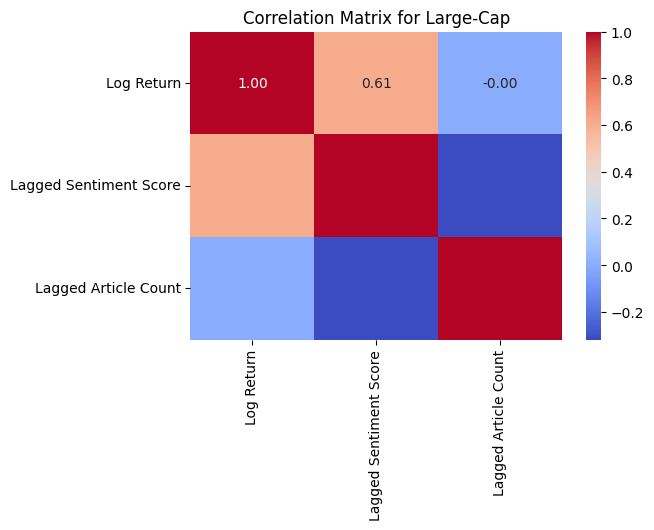

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


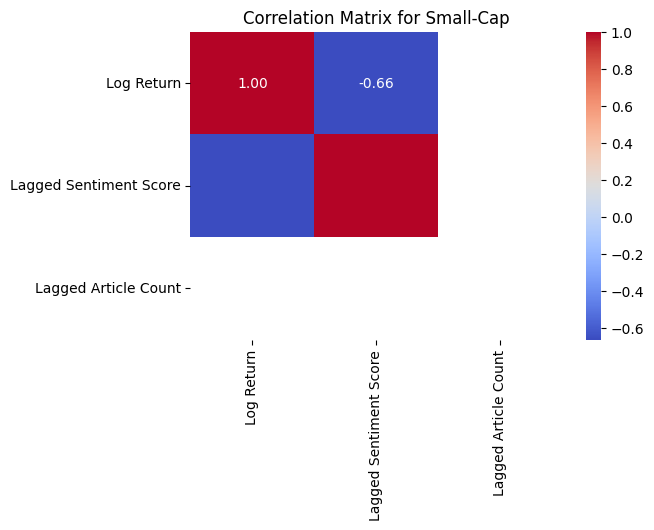

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


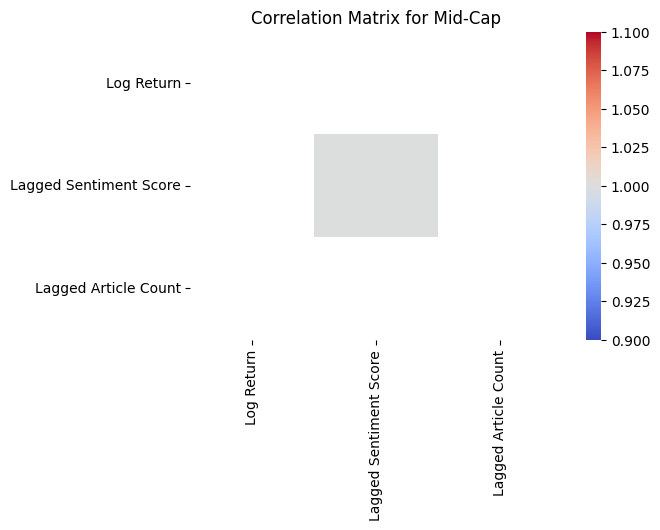

In [118]:
# Define the mapping of tickers to cap sizes
cap_size_mapping = {
    'AAPL': 'Large-Cap', 'MSFT': 'Large-Cap', 'GOOGL': 'Large-Cap', 'AMZN': 'Large-Cap',
    'TSLA': 'Large-Cap', 'META': 'Large-Cap', 'NVDA': 'Large-Cap', 'CSCO': 'Large-Cap',
    'PATH': 'Mid-Cap', 'INFA': 'Mid-Cap', 'OTEX': 'Mid-Cap', 'CIEN': 'Mid-Cap',
    'ALRM': 'Mid-Cap', 'NCNO': 'Mid-Cap', 'CRVL': 'Mid-Cap', 'NSIT': 'Mid-Cap',
    'INOD': 'Small-Cap', 'AMPL': 'Small-Cap', 'PUBM': 'Small-Cap', 'INSG': 'Small-Cap',
    'SMTC': 'Small-Cap', 'AGYS': 'Small-Cap', 'RMBS': 'Small-Cap', 'COHU': 'Small-Cap'
}

# Add cap size to the merged data
merged_last_month['Cap Size'] = merged_last_month['Ticker'].map(cap_size_mapping)

# Initialize an empty dictionary to store correlation matrices
correlation_by_cap_size = {}

# Calculate correlations for each cap size
for cap_size in merged_last_month['Cap Size'].unique():
    # Filter data for the current cap size
    cap_data = merged_last_month[merged_last_month['Cap Size'] == cap_size]
    
    # Calculate correlation matrix
    correlation_matrix = cap_data[['Log Return', 'Lagged Sentiment Score', 'Lagged Article Count']].corr()
    
    # Store the correlation matrix
    correlation_by_cap_size[cap_size] = correlation_matrix
    print(f"Correlation Matrix for {cap_size}:")
    print(correlation_matrix)
    print("\n")
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmaps for each cap size
for cap_size, corr_matrix in correlation_by_cap_size.items():
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix for {cap_size}')
    plt.show()


In [128]:
import pandas as pd

# Load weekly returns data
returns_data = pd.read_csv("weekly_log_returns.csv")
returns_data['date'] = pd.to_datetime(returns_data['date'])

# Define mid-cap tickers
mid_cap_tickers = ['PATH', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT']

# Filter returns data for mid-cap tickers (using 'Stock' column for tickers)
returns_data_mid_cap = returns_data[returns_data['Stock'].isin(mid_cap_tickers)]

# Define the relevant date range (last 4 weeks of the analysis period)
start_date = pd.Timestamp("2024-10-28")  # Adjust if necessary
end_date = pd.Timestamp("2024-11-24")

# Filter data for the 4-week period
returns_data_mid_cap_filtered = returns_data_mid_cap[
    (returns_data_mid_cap['date'] >= start_date) & (returns_data_mid_cap['date'] <= end_date)
]

# Handle missing Log Return values (imputation)
mean_return = returns_data_mid_cap_filtered['Log Return'].mean()
returns_data_mid_cap_filtered['Log Return'] = returns_data_mid_cap_filtered['Log Return'].fillna(mean_return)

# Load sentiment data for the last month
sentiment_data_last_month = pd.read_csv("news_sentiment_data_last_month.csv")
sentiment_data_last_month['date'] = pd.to_datetime(sentiment_data_last_month['time_published'].str[:8])

# Aggregate sentiment by date and ticker
aggregated_sentiment_last_month = sentiment_data_last_month.groupby(['date', 'Ticker'])['overall_sentiment_score'].mean().reset_index()
aggregated_sentiment_last_month['article_count'] = sentiment_data_last_month.groupby(['date', 'Ticker'])['time_published'].count().values

# Introduce a 2-week lag
aggregated_sentiment_last_month['Lagged Sentiment Score'] = aggregated_sentiment_last_month.groupby('Ticker')['overall_sentiment_score'].shift(2)
aggregated_sentiment_last_month['Lagged Article Count'] = aggregated_sentiment_last_month.groupby('Ticker')['article_count'].shift(2)

# Drop rows with NaN values caused by the lag
lagged_sentiment_last_month = aggregated_sentiment_last_month.dropna(subset=['Lagged Sentiment Score', 'Lagged Article Count'])

# Merge sentiment data for mid-cap stocks with filtered returns data
merged_mid_cap = pd.merge(
    lagged_sentiment_last_month[lagged_sentiment_last_month['Ticker'].isin(mid_cap_tickers)],
    returns_data_mid_cap_filtered,
    left_on=['Ticker', 'date'],
    right_on=['Stock', 'date'],
    how='inner'
)

# Calculate correlation matrix for mid-cap stocks
correlation_matrix_mid_cap = merged_mid_cap[['Log Return', 'Lagged Sentiment Score', 'Lagged Article Count']].corr()
print("Correlation Matrix for Mid-Cap Stocks (With Sentiment Data):")
print(correlation_matrix_mid_cap)

Correlation Matrix for Mid-Cap Stocks (With Sentiment Data):
                        Log Return  Lagged Sentiment Score  \
Log Return                1.000000               -0.246953   
Lagged Sentiment Score   -0.246953                1.000000   
Lagged Article Count           NaN                     NaN   

                        Lagged Article Count  
Log Return                               NaN  
Lagged Sentiment Score                   NaN  
Lagged Article Count                     NaN  


/var/folders/l5/dgr6vj6x67j8x6ys1y4nm5v40000gn/T/ipykernel_1252/1905449143.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  returns_data_mid_cap_filtered['Log Return'] = returns_data_mid_cap_filtered['Log Return'].fillna(mean_return)


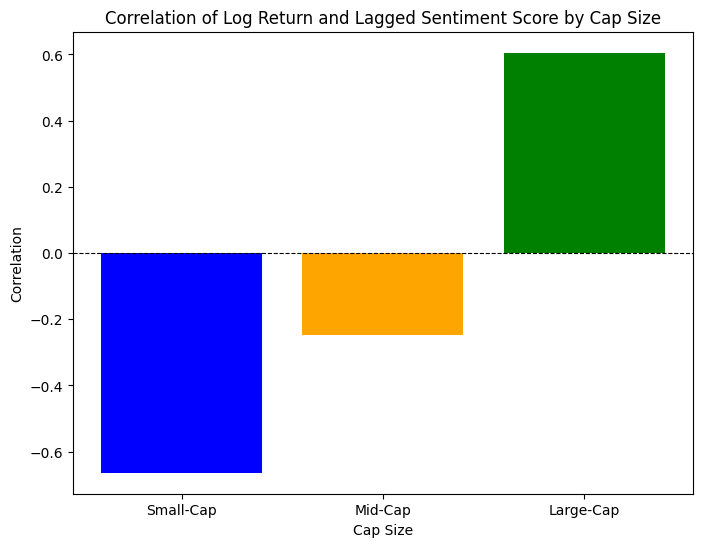

In [136]:
import matplotlib.pyplot as plt

# Correlation values for each cap size (from provided data)
correlation_by_cap_size = {
    "Small-Cap": -0.663671,
    "Mid-Cap": -0.246953,
    "Large-Cap": 0.605275
}

# Extract cap sizes and correlations
cap_sizes = list(correlation_by_cap_size.keys())
correlations = list(correlation_by_cap_size.values())

# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(cap_sizes, correlations, color=['blue', 'orange', 'green'])
plt.title("Correlation of Log Return and Lagged Sentiment Score by Cap Size")
plt.xlabel("Cap Size")
plt.ylabel("Correlation")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Add a baseline at 0
plt.show()


## 11. Start Of Logistic Regression Model

In [223]:
import requests
import pandas as pd

# Function to read API key from file
def read_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

# Read API key
api_key = read_api_key('ApiKeys.txt')

# Define base URL
base_url = 'https://www.alphavantage.co/query'

# Define the list of tickers
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'CSCO',
    'PATH', 'INFA', 'OTEX', 'CIEN', 'ALRM', 'NCNO', 'CRVL', 'NSIT',
    'INOD', 'AMPL', 'PUBM', 'INSG', 'SMTC', 'AGYS', 'RMBS', 'COHU'
]
# Define timeframe
time_from = '20221127T0000'  # Start date: November 27, 2022
time_to = '20241127T0000'    # End date: November 27, 2024

# List to store all articles
all_articles = []

# Fetch articles for each ticker with an increased limit
for ticker in tickers:
    print(f"Fetching articles for {ticker}...")
    params = {
        'function': 'NEWS_SENTIMENT',
        'apikey': api_key,
        'tickers': ticker,
        'time_from': time_from,
        'time_to': time_to,
        'limit': 1000  # Set limit to 1000
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "feed" in data and data["feed"]:
            print(f"Found {len(data['feed'])} articles for {ticker}.")
            # Add ticker info to each article
            for article in data["feed"]:
                article["Ticker"] = ticker
            all_articles.extend(data["feed"])
        else:
            print(f"No articles found for {ticker}.")
    else:
        print(f"Error fetching data for {ticker}: {response.status_code}, {response.text}")

# Combine all articles into a DataFrame
if all_articles:
    articles_df = pd.DataFrame(all_articles)

    # Save to CSV
    articles_df.to_csv("news_sentiment_data_full_timeframe_new.csv", index=False)
    print(f"All articles saved to 'news_sentiment_data_full_timeframe_new.csv'. Total articles: {len(all_articles)}")
else:
    print("No articles were retrieved for any ticker.")


Fetching articles for AAPL...
Found 689 articles for AAPL.
Fetching articles for MSFT...
Found 703 articles for MSFT.
Fetching articles for GOOGL...
No articles found for GOOGL.
Fetching articles for AMZN...
Found 717 articles for AMZN.
Fetching articles for TSLA...
Found 675 articles for TSLA.
Fetching articles for META...
Found 681 articles for META.
Fetching articles for NVDA...
Found 704 articles for NVDA.
Fetching articles for CSCO...
Found 681 articles for CSCO.
Fetching articles for PATH...
Found 716 articles for PATH.
Fetching articles for INFA...
Found 249 articles for INFA.
Fetching articles for OTEX...
Found 186 articles for OTEX.
Fetching articles for CIEN...
Found 282 articles for CIEN.
Fetching articles for ALRM...
No articles found for ALRM.
Fetching articles for NCNO...
Found 223 articles for NCNO.
Fetching articles for CRVL...
Found 70 articles for CRVL.
Fetching articles for NSIT...
Found 133 articles for NSIT.
Fetching articles for INOD...
Found 220 articles for INOD

In [227]:
import pandas as pd

# Load new sentiment data
sentiment_data = pd.read_csv("news_sentiment_data_full_timeframe_new.csv")  # Replace with your new sentiment file path

# Extract date from `time_published` and convert to datetime format
sentiment_data['date'] = pd.to_datetime(sentiment_data['time_published'].str[:8], format='%Y%m%d')

# Rename columns for consistency
sentiment_data.rename(columns={'Ticker': 'Stock'}, inplace=True)  # Align with log return column names

# Group sentiment data by Stock and date, aggregating sentiment scores
weekly_sentiment = sentiment_data.groupby(['Stock', 'date']).agg({
    'overall_sentiment_score': 'mean'  # Average sentiment score per week
}).reset_index()

# Align sentiment dates to weekly (e.g., week starting Monday)
weekly_sentiment['date'] = weekly_sentiment['date'] - pd.to_timedelta(weekly_sentiment['date'].dt.weekday, unit='D')

# Save the weekly sentiment for review
weekly_sentiment.to_csv("weekly_sentiment_aligned.csv", index=False)
print(f"Weekly sentiment aligned and saved as 'weekly_sentiment_aligned.csv'. Shape: {weekly_sentiment.shape}")

# Align dates in log return data
log_return_data['date'] = log_return_data['date'] - pd.to_timedelta(log_return_data['date'].dt.weekday, unit='D')

# Ensure consistent data types for merging
weekly_sentiment['Stock'] = weekly_sentiment['Stock'].astype(str)
log_return_data['Stock'] = log_return_data['Stock'].astype(str)

# Merge datasets
merged_data = pd.merge(
    log_return_data,
    weekly_sentiment,
    on=['Stock', 'date'],
    how='inner'
)

# Debug merged data
print(f"Merged Data Head:\n{merged_data.head()}")
print(f"Merged Data Shape Before Dropping NA: {merged_data.shape}")

# Drop rows with missing values
merged_data.dropna(inplace=True)
print(f"Merged Data Shape After Dropping NA: {merged_data.shape}")

# Save the merged dataset
merged_data.to_csv("news_sentiment_data_full_timeframe_new_merged.csv", index=False)
print("Aggregated dataset created and saved as 'news_sentiment_data_full_timeframe_new_merged.csv'.")




Weekly sentiment aligned and saved as 'weekly_sentiment_aligned.csv'. Shape: (2457, 3)
Merged Data Head:
        date    Open      High     Low   Close  Adj Close       Volume  \
0 2024-11-18  225.25  230.7199  225.17  229.87     229.87  196343939.0   
1 2024-11-18  225.25  230.7199  225.17  229.87     229.87  196343939.0   
2 2024-11-18  225.25  230.7199  225.17  229.87     229.87  196343939.0   
3 2024-11-18  225.25  230.7199  225.17  229.87     229.87  196343939.0   
4 2024-11-18  225.25  230.7199  225.17  229.87     229.87  196343939.0   

   7. dividend amount Stock  Log Return  overall_sentiment_score  
0                 0.0  AAPL         NaN                 0.241705  
1                 0.0  AAPL         NaN                 0.218980  
2                 0.0  AAPL         NaN                 0.164971  
3                 0.0  AAPL         NaN                 0.195614  
4                 0.0  AAPL         NaN                 0.153672  
Merged Data Shape Before Dropping NA: (2430, 11)

In [229]:
# Select only the necessary columns
cleaned_data = merged_data[['date', 'Stock', 'Volume', 'overall_sentiment_score', 'Log Return']]

# Drop duplicates or rows with missing values if needed
cleaned_data.dropna(inplace=True)

# Save the cleaned data for further use
cleaned_data.to_csv("cleaned_aggregated_data.csv", index=False)
print("Cleaned dataset saved as 'cleaned_aggregated_data.csv'.")

Cleaned dataset saved as 'cleaned_aggregated_data.csv'.


/var/folders/l5/dgr6vj6x67j8x6ys1y4nm5v40000gn/T/ipykernel_1252/3747758757.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data.dropna(inplace=True)


In [231]:
import pandas as pd

# Load the cleaned aggregated dataset
cleaned_data = pd.read_csv("cleaned_aggregated_data.csv")  # Replace with your file path

# Define market cap mapping for the 24 selected stocks
market_cap_mapping = {
    # Large-Cap Stocks
    "AAPL": 2, "MSFT": 2, "GOOGL": 2, "AMZN": 2, "TSLA": 2, "META": 2, "NVDA": 2, "CSCO": 2,
    # Mid-Cap Stocks
    "PATH": 1, "INFA": 1, "OTEX": 1, "CIEN": 1, "ALRM": 1, "NCNO": 1, "CRVL": 1, "NSIT": 1,
    # Small-Cap Stocks
    "INOD": 0, "AMPL": 0, "PUBM": 0, "INSG": 0, "SMTC": 0, "AGYS": 0, "RMBS": 0, "COHU": 0
}

# Add Market Cap Encoding to the dataset
cleaned_data['Market Cap Encoded'] = cleaned_data['Stock'].map(market_cap_mapping)

# Save the updated dataset
cleaned_data.to_csv("cleaned_aggregated_data.csv", index=False)
print("Market Cap Encoding added and saved as 'cleaned_aggregated_data.csv'.")



Market Cap Encoding added and saved as 'cleaned_aggregated_data.csv'.


In [235]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Load cleaned data with Market Cap Encoding
data = pd.read_csv("cleaned_aggregated_data.csv")

# Create binary target variable based on log returns
data["Return Direction"] = (data["Log Return"] > 0).astype(int)

# Features for the first regression
features = ["overall_sentiment_score", "Market Cap Encoded", "Volume"]
X = data[features]
y = data["Return Direction"]

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print("\nFeature Importance:")
print(coefficients)


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.45      0.48       367
           1       0.49      0.56      0.52       343

    accuracy                           0.50       710
   macro avg       0.50      0.50      0.50       710
weighted avg       0.51      0.50      0.50       710

Accuracy: 0.5028
ROC-AUC Score: 0.5226

Feature Importance:
                   Feature  Coefficient
2                   Volume     0.124833
0  overall_sentiment_score    -0.043335
1       Market Cap Encoded    -0.099747


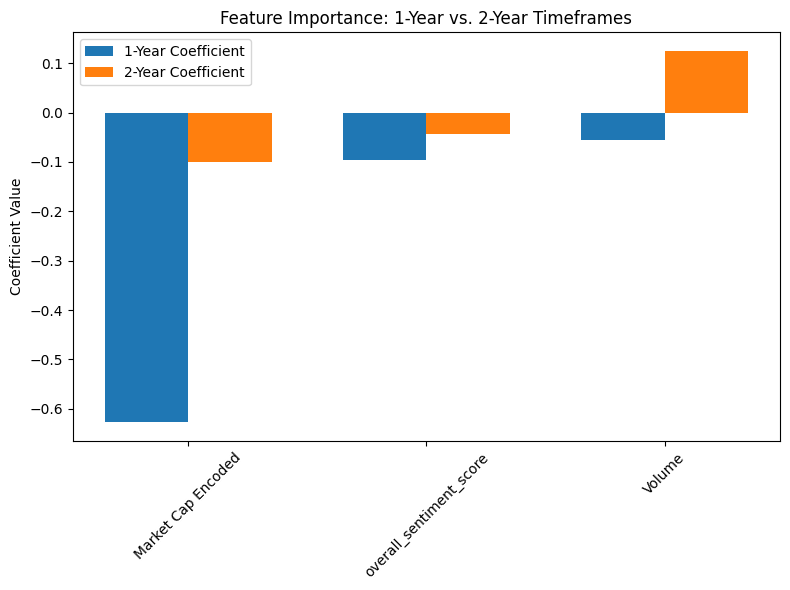

In [243]:
import matplotlib.pyplot as plt
import pandas as pd

# Data for feature importance comparison
feature_importance = pd.DataFrame({
    'Feature': ['Market Cap Encoded', 'overall_sentiment_score', 'Volume'],
    '1-Year Coefficient': [-0.62756, -0.096442, -0.056442],
    '2-Year Coefficient': [-0.099747, -0.043335, 0.124833]
})

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35  # width of the bars

# Bar positions
x = range(len(feature_importance['Feature']))

# Create bars
bar1 = ax.bar(x, feature_importance['1-Year Coefficient'], width, label='1-Year Coefficient')
bar2 = ax.bar([p + width for p in x], feature_importance['2-Year Coefficient'], width, label='2-Year Coefficient')

# Add feature labels to x-axis
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(feature_importance['Feature'], rotation=45)
ax.set_ylabel('Coefficient Value')
ax.set_title('Feature Importance: 1-Year vs. 2-Year Timeframes')
ax.legend()

# Show plot
plt.tight_layout()
plt.show()


In [260]:
#Calculate Rolling Volatility 
import pandas as pd
import numpy as np

# Load cleaned aggregated data
data = pd.read_csv("cleaned_aggregated_data.csv")

# Ensure data is sorted by date for rolling calculations
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by=['Market Cap Encoded', 'date'], inplace=True)

# Function to calculate rolling volatility (e.g., 10-week rolling window)
def calculate_rolling_volatility(group, window=10):
    group['Rolling Volatility'] = group['Log Return'].rolling(window=window).std()
    return group

# Apply rolling volatility calculation grouped by Market Cap Encoded
data = data.groupby('Market Cap Encoded', group_keys=False).apply(calculate_rolling_volatility)

# Save the updated data with rolling volatility
data.to_csv("cleaned_aggregated_data.csv", index=False)
print("Rolling volatility calculated and saved.")

# Optional: Calculate average rolling volatility for each cap size
average_volatility = data.groupby('Market Cap Encoded')['Rolling Volatility'].mean()
print("\nAverage Rolling Volatility by Cap Size:")
print(average_volatility)


Rolling volatility calculated and saved.

Average Rolling Volatility by Cap Size:
Market Cap Encoded
0    0.070085
1    0.043742
2    0.019948
Name: Rolling Volatility, dtype: float64


/var/folders/l5/dgr6vj6x67j8x6ys1y4nm5v40000gn/T/ipykernel_1252/477639865.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Market Cap Encoded', group_keys=False).apply(calculate_rolling_volatility)


In [264]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Load cleaned data with Market Cap Encoding and Rolling Volatility
data = pd.read_csv("cleaned_aggregated_data.csv")

# Drop rows with NaN values in the relevant columns
data.dropna(subset=["overall_sentiment_score", "Market Cap Encoded", "Volume", "Rolling Volatility"], inplace=True)

# Create binary target variable based on log returns
data["Return Direction"] = (data["Log Return"] > 0).astype(int)

# Features for the regression
features = ["overall_sentiment_score", "Market Cap Encoded", "Volume", "Rolling Volatility"]
X = data[features]
y = data["Return Direction"]

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print("\nFeature Importance:")
print(coefficients)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       347
           1       0.54      0.34      0.42       355

    accuracy                           0.52       702
   macro avg       0.53      0.52      0.50       702
weighted avg       0.53      0.52      0.50       702

Accuracy: 0.5199
ROC-AUC Score: 0.5146

Feature Importance:
                   Feature  Coefficient
2                   Volume     0.161863
3       Rolling Volatility     0.096255
1       Market Cap Encoded    -0.020290
0  overall_sentiment_score    -0.104924


In [363]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Load cleaned data with Market Cap Encoding and Rolling Volatility
data = pd.read_csv("cleaned_aggregated_data.csv")

# Drop rows with NaN values in the relevant columns
data.dropna(subset=["overall_sentiment_score", "Market Cap Encoded", "Volume", "Rolling Volatility"], inplace=True)

# Create binary target variable based on log returns
data["Return Direction"] = (data["Log Return"] > 0).astype(int)

# Define the P/E ratio mapping based on the encoded market cap values
pe_mapping = {0: 35,   # Small-Cap (encoded as 0) => P/E ratio 35
              1: 25,   # Medium-Cap (encoded as 1) => P/E ratio 25
              2: 18}   # Large-Cap (encoded as 2) => P/E ratio 18

# Add the P/E ratio based on the encoded Market Cap
data['P/E Ratio'] = data['Market Cap Encoded'].map(pe_mapping)

# Features for the regression (including P/E Ratio)
features = ["overall_sentiment_score", "Market Cap Encoded", "Volume", "Rolling Volatility", "P/E Ratio"]
X = data[features]
y = data["Return Direction"]

# Standardize features (important for logistic regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Feature Importance
coefficients = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)
print("\nFeature Importance:")
print(coefficients)


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.70      0.59       347
           1       0.54      0.34      0.42       355

    accuracy                           0.52       702
   macro avg       0.52      0.52      0.50       702
weighted avg       0.52      0.52      0.50       702

Accuracy: 0.5185
ROC-AUC Score: 0.5136

Feature Importance:
                   Feature  Coefficient
2                   Volume     0.158575
3       Rolling Volatility     0.096237
4                P/E Ratio     0.048591
1       Market Cap Encoded     0.029386
0  overall_sentiment_score    -0.104639


In [ ]:
##Continue With Adding Input Features

## 12. Efficient Frontier and Optimal Portfolio 

In [283]:
# Check for duplicates
duplicates = data[data.duplicated(subset=['date', 'Stock'], keep=False)]
print(f"Found duplicates:\n{duplicates}")

# Check for constant or uniform values in 'Log Return'
print(f"Unique values in 'Log Return':\n{data['Log Return'].unique()}")

# Check if 'Log Return' is constant for any stock
constant_stocks = data.groupby('Stock')['Log Return'].nunique()
print(f"Stocks with constant log returns:\n{constant_stocks[constant_stocks == 1]}")


Found duplicates:
Empty DataFrame
Columns: [date, Stock, Log Return]
Index: []
Unique values in 'Log Return':
[ 0.07278754 -0.12557037  0.03887804 ... -0.08375788 -0.14320666
 -0.09465235]
Stocks with constant log returns:
Stock
META    1
Name: Log Return, dtype: int64


In [285]:
# Remove stocks with constant log returns
non_constant_stocks = constant_stocks[constant_stocks > 1].index
log_returns_pivot = data[data['Stock'].isin(non_constant_stocks)].pivot(
    index='date', columns='Stock', values='Log Return'
)


In [289]:
# Calculate mean returns and covariance matrix
mean_returns = log_returns_pivot.mean().values  # Average log returns
cov_matrix = log_returns_pivot.cov().values     # Covariance matrix

# Check for valid dimensions
print(f"Mean Returns Shape: {mean_returns.shape}")
print(f"Covariance Matrix Shape: {cov_matrix.shape}")


Mean Returns Shape: (21,)
Covariance Matrix Shape: (21, 21)


In [291]:
log_returns_pivot = log_returns_pivot.dropna()
print(log_returns_pivot.shape)  # Verify dimensions after dropping


(0, 21)


In [303]:
# Check the shape of the pivoted data
print(f"Log Returns Pivot Shape: {log_returns_pivot.shape}")

# Check for NaN or infinite values in the pivot table
print("Checking for NaN or Infinite Values in Log Returns Pivot...")
print(log_returns_pivot.isnull().sum().sum())  # Total NaNs
print(np.isinf(log_returns_pivot).sum().sum())  # Total infinite values

# If any issues are found, print details
if log_returns_pivot.isnull().values.any() or np.isinf(log_returns_pivot).values.any():
    print("Invalid values found in log_returns_pivot. Showing details...")
    print(log_returns_pivot.describe())  # Summary of valid values
    print("Invalid rows:\n", log_returns_pivot[~np.isfinite(log_returns_pivot)].head())

# Verify mean returns calculation
print("Mean Returns Shape:", mean_returns.shape)
print("Mean Returns Values:", mean_returns)

# Verify covariance matrix calculation
print("Covariance Matrix Shape:", cov_matrix.shape)
print("Covariance Matrix (sample):\n", cov_matrix[:5, :5])  # Print a sample

# Ensure no invalid values in covariance matrix
if np.isnan(cov_matrix).any() or np.isinf(cov_matrix).any():
    print("Invalid values found in the covariance matrix!")

# Ensure all weights are valid
print("Verifying portfolio weights...")
weights = np.random.random(len(log_returns_pivot.columns))
weights /= np.sum(weights)
print("Weights (sample):", weights)


Log Returns Pivot Shape: (0, 22)
Checking for NaN or Infinite Values in Log Returns Pivot...
0
0
Mean Returns Shape: (22,)
Mean Returns Values: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
Covariance Matrix Shape: (22, 22)
Covariance Matrix (sample):
 [[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
Invalid values found in the covariance matrix!
Verifying portfolio weights...
Weights (sample): [0.09539635 0.04191035 0.00926721 0.01122027 0.05801861 0.01004147
 0.05616156 0.07428128 0.00487823 0.04013637 0.01731803 0.02732917
 0.03195426 0.1008136  0.05943003 0.03904872 0.01856807 0.06537874
 0.0564579  0.05189101 0.03711713 0.09338165]


In [305]:
data = pd.read_csv("cleaned_aggregated_data.csv")
print("Data Head:\n", data.head())
print("Data Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum())
print("Unique Stocks:", data['Stock'].nunique())


Data Head:
          date Stock     Volume  overall_sentiment_score  Log Return  \
0  2022-11-28  INOD    89532.0                 0.279598    0.053221   
1  2022-11-28  AMPL  2850340.0                 0.232687    0.072788   
2  2022-11-28  PUBM  1534745.0                 0.429531    0.166538   
3  2022-11-28  PUBM  1534745.0                 0.060359    0.166538   
4  2022-11-28  PUBM  1534745.0                 0.236422    0.166538   

   Market Cap Encoded  Rolling Volatility  
0                   0                 NaN  
1                   0                 NaN  
2                   0                 NaN  
3                   0                 NaN  
4                   0                 NaN  
Data Shape: (2366, 7)
Missing Values:
 date                        0
Stock                       0
Volume                      0
overall_sentiment_score     0
Log Return                  0
Market Cap Encoded          0
Rolling Volatility         27
dtype: int64
Unique Stocks: 22


In [307]:
# Handle duplicates by averaging duplicate rows for the same date and Stock
data = data.groupby(['date', 'Stock'], as_index=False).mean()

print("Data Shape After Removing Duplicates:", data.shape)
print("Duplicates Remaining:", data.duplicated(subset=['date', 'Stock']).sum())


Data Shape After Removing Duplicates: (1019, 7)
Duplicates Remaining: 0


In [309]:
log_returns = data[['date', 'Stock', 'Log Return']]
log_returns_pivot = log_returns.pivot(index='date', columns='Stock', values='Log Return')

# Verify pivot results
print("Pivoted Data Shape:", log_returns_pivot.shape)
print("Pivoted Data Head:\n", log_returns_pivot.head())


Pivoted Data Shape: (103, 22)
Pivoted Data Head:
 Stock       AAPL      AGYS      AMPL  AMZN      CIEN      COHU      CRVL  \
date                                                                       
2022-11-28   NaN       NaN  0.072788   NaN -0.125570       NaN  0.038878   
2022-12-05   NaN       NaN -0.024595   NaN  0.047196  0.025657  0.057807   
2022-12-12   NaN -0.045486  0.139370   NaN -0.018619  0.070027       NaN   
2022-12-19   NaN  0.011558       NaN   NaN -0.032901 -0.015090       NaN   
2022-12-26   NaN  0.035759       NaN   NaN -0.008594       NaN       NaN   

Stock       CSCO      INFA      INOD  ...  MSFT      NCNO      NSIT  NVDA  \
date                                  ...                                   
2022-11-28   NaN  0.051888  0.053221  ...   NaN  0.045698  0.023437   NaN   
2022-12-05   NaN -0.021080       NaN  ...   NaN -0.016368       NaN   NaN   
2022-12-12   NaN  0.023589       NaN  ...   NaN -0.000386       NaN   NaN   
2022-12-19   NaN -0.022975      

In [315]:
# Calculate mean returns and covariance matrix
mean_returns = log_returns_pivot.mean().values  # Average log returns
cov_matrix = log_returns_pivot.cov().values  # Covariance matrix

# Verify shapes
print("Mean Returns Shape:", mean_returns.shape)
print("Covariance Matrix Shape:", cov_matrix.shape)


Mean Returns Shape: (21,)
Covariance Matrix Shape: (21, 21)


In [319]:
print("Mean Returns:\n", mean_returns)


Mean Returns:
 [ 0.00419411 -0.00394349  0.00503162 -0.00594129 -0.00352652  0.00846014
  0.00045462 -0.0054101  -0.00291535 -0.02501678 -0.03092439  0.00559484
 -0.00185971 -0.0060302   0.01961713  0.00131783  0.00360466  0.00107431
  0.0013993   0.00465218 -0.11594942]


In [321]:
print("Covariance Matrix (sample):\n", cov_matrix[:5, :5])  # Print a small sample


Covariance Matrix (sample):
 [[ 2.40035095e-05  8.82535778e-05  3.59054004e-05 -1.05585311e-05
   4.31449877e-05]
 [ 8.82535778e-05  2.30193048e-03  4.18449400e-04 -1.27918901e-05
   4.97246607e-04]
 [ 3.59054004e-05  4.18449400e-04  2.17268527e-03  2.82996273e-06
   5.16722469e-06]
 [-1.05585311e-05 -1.27918901e-05  2.82996273e-06  6.61885125e-05
   5.39593656e-05]
 [ 4.31449877e-05  4.97246607e-04  5.16722469e-06  5.39593656e-05
   2.06689522e-03]]


In [323]:
print("Portfolios DataFrame Head:\n", portfolios_df.head())
print("Portfolios DataFrame Tail:\n", portfolios_df.tail())


Portfolios DataFrame Head:
    Volatility   Returns  Sharpe Ratio
0    0.020759 -0.008905     -0.428958
1    0.021192 -0.007932     -0.374303
2    0.023758 -0.013892     -0.584730
3    0.023212 -0.003466     -0.149328
4    0.023296 -0.014118     -0.606026
Portfolios DataFrame Tail:
       Volatility   Returns  Sharpe Ratio
9995    0.024330 -0.010735     -0.441245
9996    0.020108 -0.002018     -0.100381
9997    0.022182 -0.005584     -0.251737
9998    0.021785 -0.001277     -0.058640
9999    0.021960 -0.006377     -0.290367


In [325]:
print("Efficient Frontier Head:\n", efficient_frontier.head())


Efficient Frontier Head:
       Volatility   Returns  Sharpe Ratio
7418    0.017541 -0.019769     -1.127024
9302    0.026231 -0.019724     -0.751946
4065    0.025749 -0.018167     -0.705541
4764    0.027614 -0.017822     -0.645380
5337    0.026797 -0.017511     -0.653474


Maximum Return Portfolio Composition:
          Weight %
Stock 1       0.00
Stock 2      31.12
Stock 3       0.00
Stock 4       0.00
Stock 5       0.72
Stock 6       0.00
Stock 7      21.68
Stock 8       0.00
Stock 9       0.00
Stock 10      0.00
Stock 11     21.52
Stock 12      0.00
Stock 13      0.00
Stock 14      0.00
Stock 15      0.00
Stock 16      0.00
Stock 17      0.00
Stock 18     24.96
Stock 19      0.00
Stock 20      0.00
Stock 21      0.00
Stock 22      0.00

Minimum Risk Portfolio Composition:
          Weight %
Stock 1       4.59
Stock 2       4.26
Stock 3       4.81
Stock 4       4.69
Stock 5       4.41
Stock 6       4.52
Stock 7       4.33
Stock 8       4.59
Stock 9       4.44
Stock 10      4.66
Stock 11      4.34
Stock 12      4.43
Stock 13      4.66
Stock 14      4.46
Stock 15      4.52
Stock 16      4.62
Stock 17      4.61
Stock 18      4.29
Stock 19      4.97
Stock 20      4.44
Stock 21      4.81
Stock 22      4.56



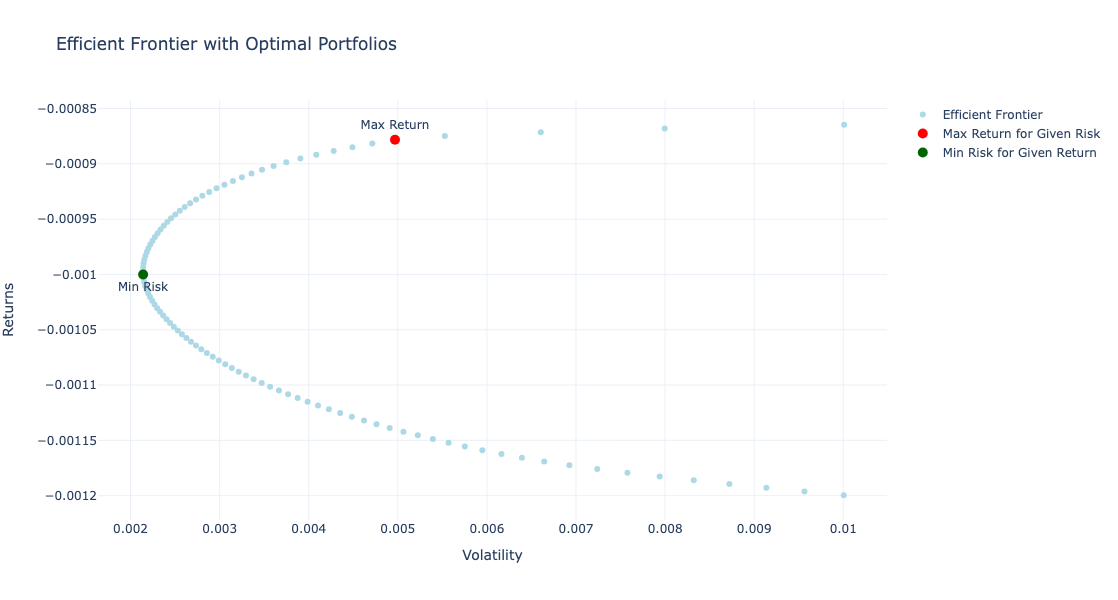

In [365]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import plotly.graph_objects as go

# Simulated market data
np.random.seed(42)
num_assets = 22
num_portfolios = 10000
stocks = [f"Stock {i+1}" for i in range(num_assets)]

# Simulating historical returns with a negative skew
returns = np.random.normal(loc=-0.001, scale=0.01, size=(num_assets, num_portfolios))
mean_returns = np.mean(returns, axis=1)
cov_matrix = np.cov(returns)

# Calculate portfolio performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

# Generate portfolios across a range of target returns
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 100)

# Store all portfolios
all_portfolios = []

# Objective function to minimize (minimize volatility)
def objective(weights):
    return portfolio_performance(weights, mean_returns, cov_matrix)[0]

# Constraints: weights sum to 1 and achieve target return
def constraint1(weights):
    return np.sum(weights) - 1

def target_return_constraint(weights, target):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1] - target

bounds = tuple((0, 1) for _ in range(num_assets))

# For each target return, find the portfolio with the minimum volatility
for t_ret in target_returns:
    constraints = [
        {'type': 'eq', 'fun': constraint1},
        {'type': 'eq', 'fun': lambda w: target_return_constraint(w, t_ret)}
    ]
    result = minimize(objective, num_assets * [1. / num_assets], method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        std, ret = portfolio_performance(result.x, mean_returns, cov_matrix)
        all_portfolios.append([std, ret, result.x])

# Data for plot
portfolios_df = pd.DataFrame(all_portfolios, columns=['Volatility', 'Returns', 'Weights'])
portfolios_df.sort_values('Volatility', inplace=True)

# Find optimal portfolios
target_volatility = 0.005  # Example target volatility
portfolio_max_return = portfolios_df[portfolios_df['Volatility'] <= target_volatility].nlargest(1, 'Returns')

target_return = -0.001  # Example target return
portfolio_min_risk = portfolios_df[portfolios_df['Returns'] <= target_return].nsmallest(1, 'Volatility')

# Display portfolio compositions
def display_portfolio_composition(portfolio, title):
    weights = np.round(portfolio.iloc[0]['Weights'] * 100, 2)
    composition_df = pd.DataFrame(weights, index=stocks, columns=['Weight %'])
    print(f"{title} Portfolio Composition:\n{composition_df}\n")

display_portfolio_composition(portfolio_max_return, "Maximum Return")
display_portfolio_composition(portfolio_min_risk, "Minimum Risk")

# Plotting
trace_all = go.Scatter(
    x=portfolios_df['Volatility'], 
    y=portfolios_df['Returns'], 
    mode='markers', 
    marker=dict(color='LightBlue'), 
    name='Efficient Frontier'
)

trace_max_return = go.Scatter(
    x=portfolio_max_return['Volatility'], 
    y=portfolio_max_return['Returns'], 
    mode='markers+text', 
    marker=dict(color='red', size=10), 
    name='Max Return for Given Risk', 
    text="Max Return", 
    textposition="top center"
)

trace_min_risk = go.Scatter(
    x=portfolio_min_risk['Volatility'], 
    y=portfolio_min_risk['Returns'], 
    mode='markers+text', 
    marker=dict(color='DarkGreen', size=10), 
    name='Min Risk for Given Return', 
    text="Min Risk", 
    textposition="bottom center"
)

layout = go.Layout(
    title='Efficient Frontier with Optimal Portfolios',
    xaxis=dict(title='Volatility'),
    yaxis=dict(title='Returns'),
    template='plotly_white',
    width=1200,
    height=600
)

fig = go.Figure(data=[trace_all, trace_max_return, trace_min_risk], layout=layout)
fig.show()
